# Analyzing Neural Networks Under Adversarial Attacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchattacks

In [ ]:
!pip install grad_cam

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torchsummary import summary
import torchattacks
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/HWe"
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1: Training ResNet on noisy dataset

### 1-1: Downloading CIFAR-100 dataset

In [ ]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root=base_path, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root=base_path, train=False, download=True, transform=transform)

print(f"\nNumber of training images: {len(trainset)}")
print(f"Number of testing images: {len(testset)}")


Number of training images: 50000
Number of testing images: 10000


#### Visualizing class distributions

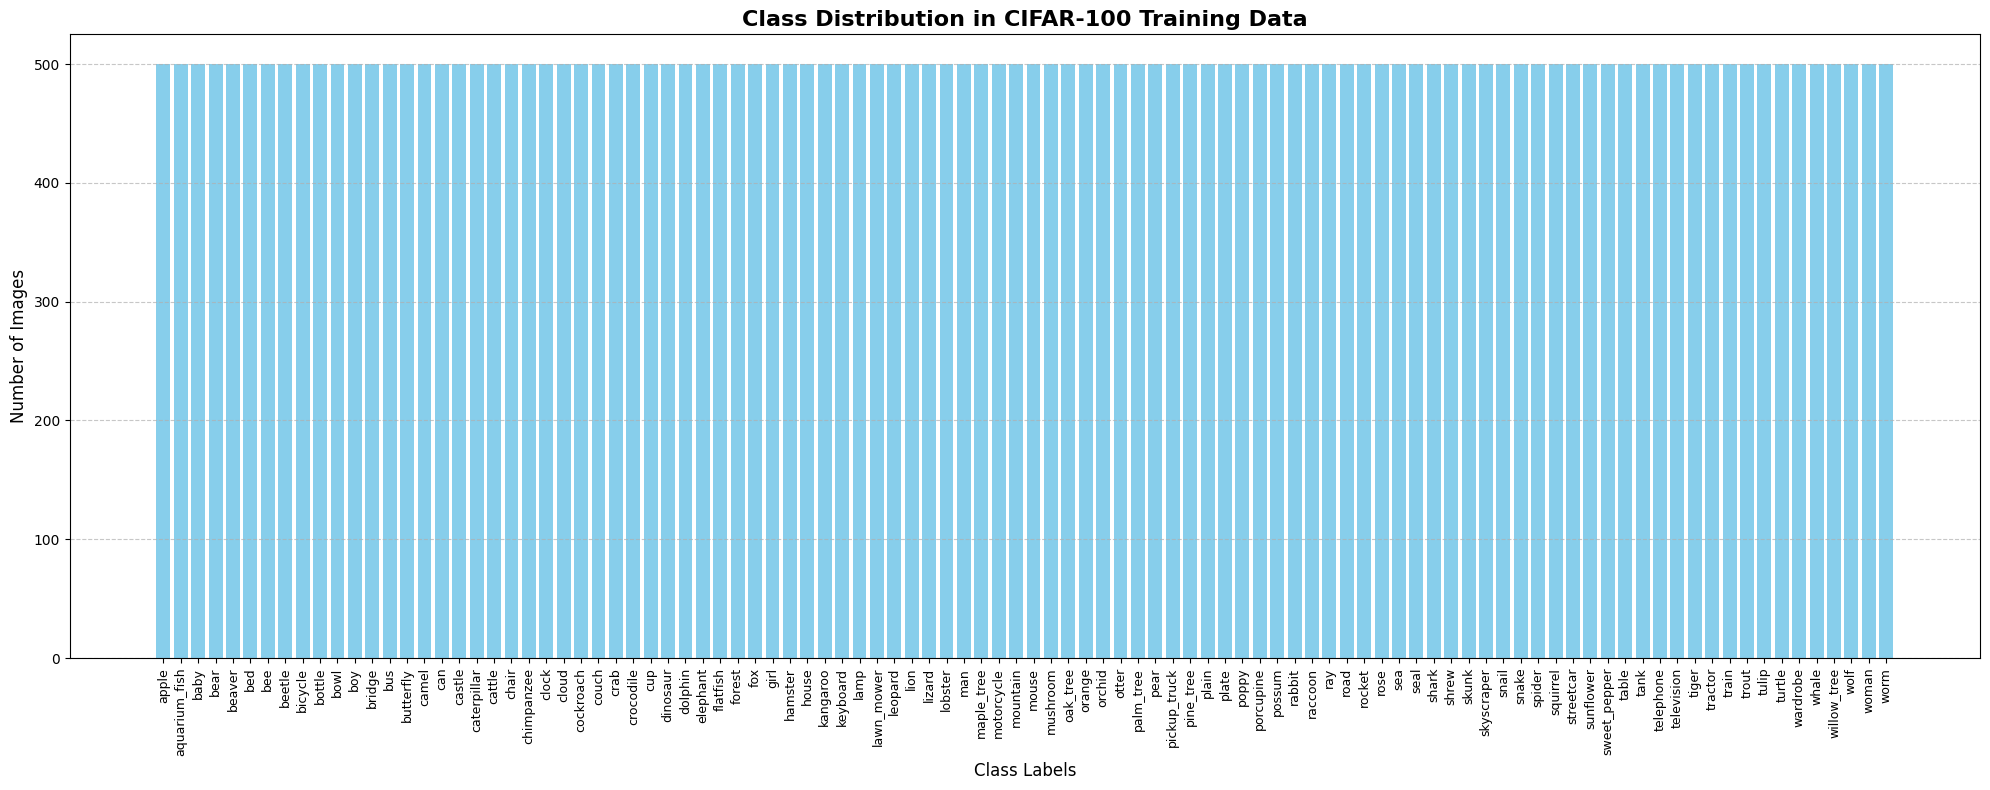

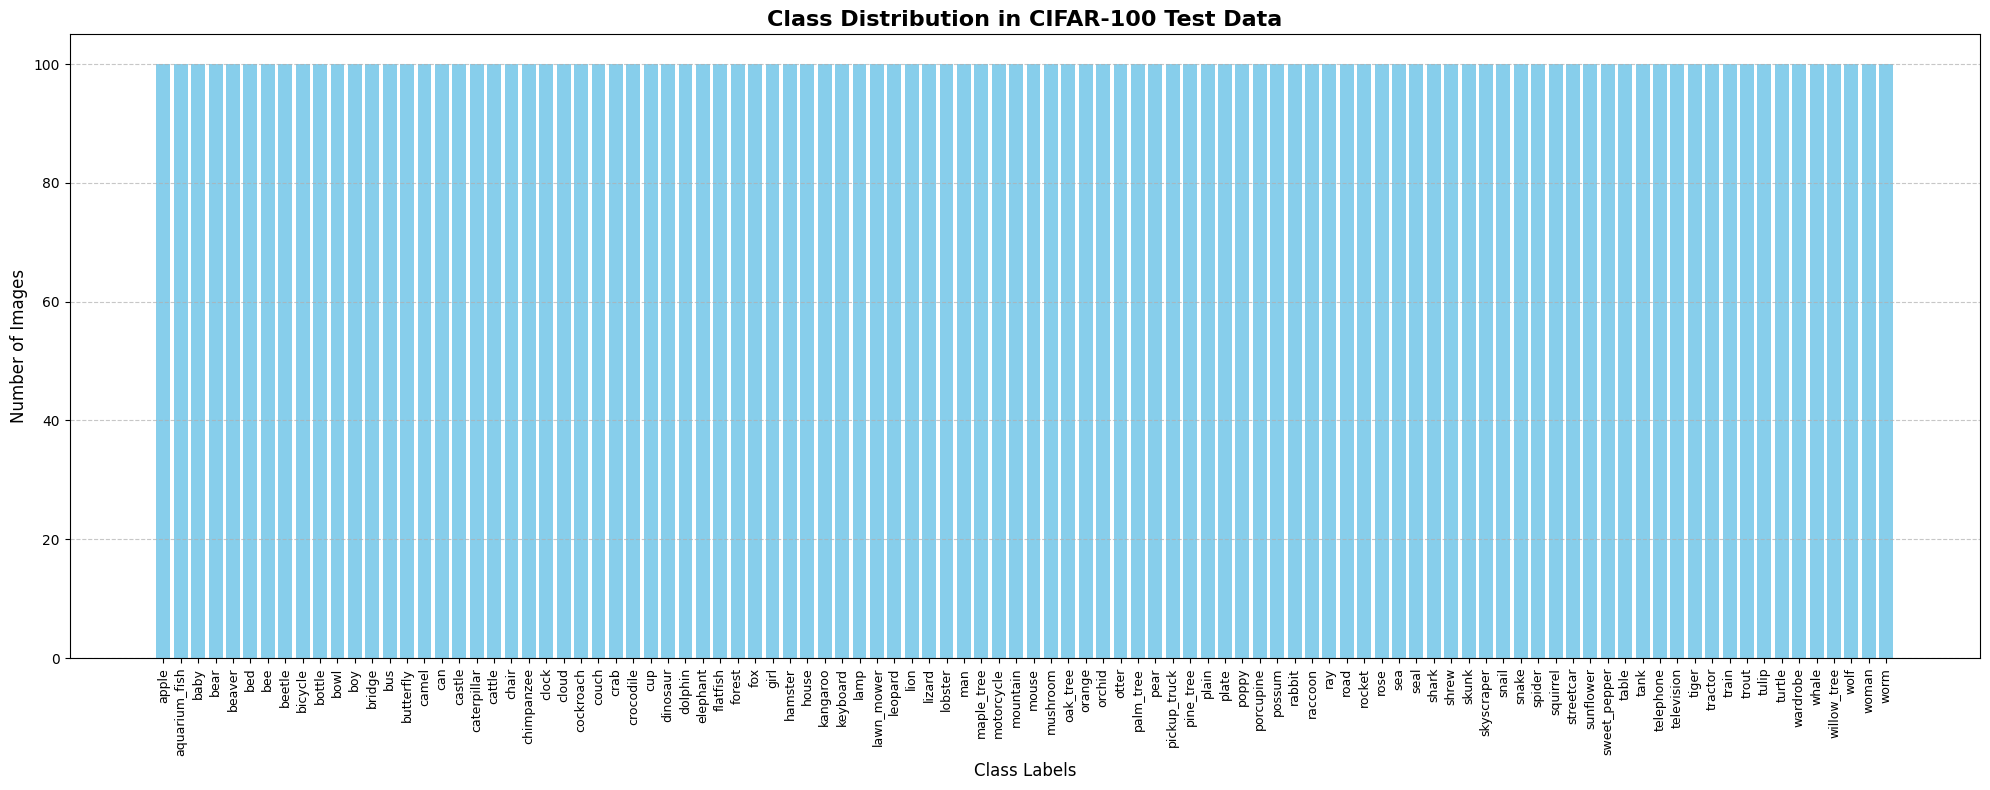

In [ ]:
fine_labels = trainset.classes
train_targets = trainset.targets
test_targets = testset.targets

train_distribution = Counter(train_targets)
test_distribution = Counter(test_targets)

train_dist_sorted = sorted(train_distribution.items())
test_dist_sorted = sorted(test_distribution.items())

train_class_indices, train_counts = zip(*train_dist_sorted)
test_class_indices, test_counts = zip(*test_dist_sorted)

def plot_class_distribution(counts, class_indices, labels, title):
    plt.figure(figsize=(20, 8))
    plt.bar([labels[i] for i in class_indices], counts, color='skyblue')
    plt.xlabel('Class Labels', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=90, fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_class_distribution(
    train_counts,
    train_class_indices,
    fine_labels,
    'Class Distribution in CIFAR-100 Training Data'
)

plot_class_distribution(
    test_counts,
    test_class_indices,
    fine_labels,
    'Class Distribution in CIFAR-100 Test Data'
)

### 1-2: Add guassian noise to train dataset

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [ ]:
variance = 0.05
noise_std = np.sqrt(variance)

In [ ]:
transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=noise_std),
    transforms.Normalize(mean, std)
])

trainset_noisy = torchvision.datasets.CIFAR100(
    root=base_path, train=True, download=True, transform=transform_noisy
)


#### Preparing train, validation and test datasets

In [ ]:
val_split = 0.1
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_split * num_train))

np.random.seed(30)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


train_subset = torch.utils.data.Subset(trainset, train_indices)
val_subset = torch.utils.data.Subset(trainset, val_indices)

train_subset_noisy = torch.utils.data.Subset(trainset_noisy, train_indices)
val_subset_noisy = torch.utils.data.Subset(trainset_noisy, val_indices)

print(f"Full training set size: {num_train}")
print(f"Training subset size:   {len(train_subset)} (90%)")
print(f"Validation subset size: {len(val_subset)} (10%)")


Full training set size: 50000
Training subset size:   45000 (90%)
Validation subset size: 5000 (10%)


In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    dataset=train_subset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)


train_loader_noisy = torch.utils.data.DataLoader(
    dataset=train_subset_noisy,
    batch_size=batch_size,
    shuffle=True
)
val_loader_noisy = torch.utils.data.DataLoader(
    dataset=val_subset_noisy,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=batch_size,
    shuffle=False
)

### 1-3: Train ResNet18 on original and noisy datasets

#### Loading ResNet18 model

In [ ]:
def create_resnet18_cifar():

    model = models.resnet18(weights=None)
    # Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)

    return model.to(device)

In [ ]:
# Original ResNet18 model architecture
orig_resnet18 = models.resnet18(weights=None)
input_shape = (3, 32, 32)
summary(orig_resnet18, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

#### Trainig function

In [ ]:
def train_model(model, model_name, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, patience):

    print(f"\n--- Starting Training for: {model_name} ---")

    model_save_path = os.path.join(base_path, f"best_{model_name}.pth")

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{correct_train / total_train:.4f}"})

        epoch_train_loss = running_loss / len(train_loader.dataset.indices)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{correct_val / total_val:.4f}"})

        epoch_val_loss = running_val_loss / len(val_loader.dataset.indices)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0

            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss vs. Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy vs. Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Loading best model weights from {model_save_path}")
    model.load_state_dict(torch.load(model_save_path))

    return model, history

#### Evaluate function

In [ ]:
def evaluate_model(model, test_loader, model_name):

    print(f"\n--- Evaluating {model_name} on the Test Set ---")
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_loss = test_loss / len(test_loader.dataset)
    final_acc = correct / total

    print(f"Test Loss: {final_loss:.4f}")
    print(f"Test Accuracy: {100 * final_acc:.2f}%")
    return final_acc, final_loss

#### Training model on original dataset

In [ ]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
PATIENCE = 7


--- Starting Training for: ResNet18_Original ---


Epoch 1/20 | Train Loss: 3.4882, Train Acc: 0.1659 | Val Loss: 3.1829, Val Acc: 0.2102


Epoch 2/20 | Train Loss: 2.5835, Train Acc: 0.3288 | Val Loss: 2.6325, Val Acc: 0.3178


Epoch 3/20 | Train Loss: 2.0399, Train Acc: 0.4470 | Val Loss: 2.1501, Val Acc: 0.4220


Epoch 4/20 | Train Loss: 1.6649, Train Acc: 0.5308 | Val Loss: 2.0777, Val Acc: 0.4402


Epoch 5/20 | Train Loss: 1.3689, Train Acc: 0.6068 | Val Loss: 1.9178, Val Acc: 0.4770


Epoch 6/20 | Train Loss: 1.0863, Train Acc: 0.6795 | Val Loss: 1.9678, Val Acc: 0.4818


Epoch 7/20 | Train Loss: 0.8378, Train Acc: 0.7466 | Val Loss: 2.0345, Val Acc: 0.4828


Epoch 8/20 | Train Loss: 0.5944, Train Acc: 0.8203 | Val Loss: 2.1150, Val Acc: 0.4858


Epoch 9/20 | Train Loss: 0.4049, Train Acc: 0.8766 | Val Loss: 2.6021, Val Acc: 0.4474


Epoch 10/20 | Train Loss: 0.1332, Train Acc: 0.9727 | Val Loss: 1.6884, Val Acc: 0.5772


Epoch 11/20 | Train Loss: 0.0548, Train Acc: 0.9955 | Val Loss: 1.6990, Val Acc: 0.5812


Epoch 12/20 | Train Loss: 0.0354, Train Acc: 0.9982 | Val Loss: 1.7201, Val Acc: 0.5798


Epoch 13/20 | Train Loss: 0.0253, Train Acc: 0.9990 | Val Loss: 1.7387, Val Acc: 0.5790


Epoch 14/20 | Train Loss: 0.0191, Train Acc: 0.9994 | Val Loss: 1.7583, Val Acc: 0.5772


Epoch 15/20 | Train Loss: 0.0152, Train Acc: 0.9997 | Val Loss: 1.7551, Val Acc: 0.5782


Epoch 16/20 | Train Loss: 0.0149, Train Acc: 0.9997 | Val Loss: 1.7578, Val Acc: 0.5794


Epoch 17/20 | Train Loss: 0.0143, Train Acc: 0.9998 | Val Loss: 1.7569, Val Acc: 0.5804
Early stopping triggered after 7 epochs with no improvement.


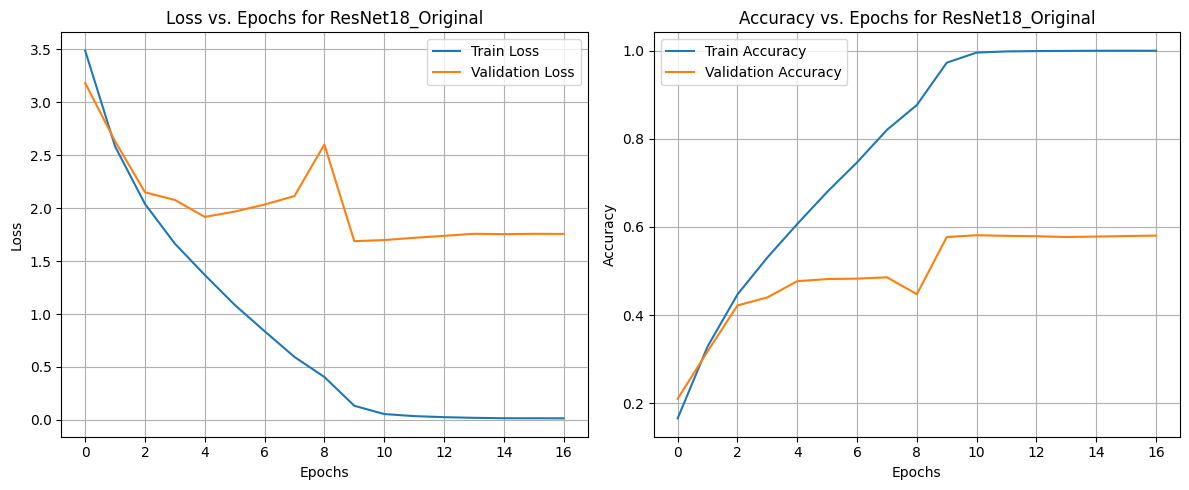

Loading best model weights from /content/drive/MyDrive/Colab Notebooks/HWe/best_ResNet18_Original.pth


In [ ]:
# Without Data Augmentation
model_original = create_resnet18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model_original.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_original = optim.lr_scheduler.ReduceLROnPlateau(optimizer_original, 'min', patience=3, factor=0.1)

best_model_original, history_original = train_model(
    model=model_original,
    model_name="ResNet18_Original",
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_original,
    scheduler=scheduler_original,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

#### Testing:

In [ ]:
transform_train_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_noisy = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=noise_std),
    transforms.Normalize(mean, std)
])


trainset_full = torchvision.datasets.CIFAR100(root=base_path, train=True, download=True, transform=transform_train_augmented)
trainset_noisy_full = torchvision.datasets.CIFAR100(root=base_path, train=True, download=True, transform=transform_noisy)

valset_full = torchvision.datasets.CIFAR100(root=base_path, train=True, download=True, transform=transform_val_test)
testset = torchvision.datasets.CIFAR100(root=base_path, train=False, download=True, transform=transform_val_test)


val_split = 0.1
num_train = len(trainset_full)
indices = list(range(num_train))
split = int(np.floor(val_split * num_train))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


train_subset = torch.utils.data.Subset(trainset_full, train_indices)
val_subset = torch.utils.data.Subset(valset_full, val_indices)
train_subset_noisy = torch.utils.data.Subset(trainset_noisy_full, train_indices)
val_subset_noisy = torch.utils.data.Subset(valset_full, val_indices)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)
train_loader_noisy = torch.utils.data.DataLoader(dataset=train_subset_noisy, batch_size=batch_size, shuffle=True)
val_loader_noisy = torch.utils.data.DataLoader(dataset=val_subset_noisy, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)


--- Starting Training for: ResNet18_Original ---


Epoch 1/20 | Train Loss: 4.1600, Train Acc: 0.0697 | Val Loss: 3.6261, Val Acc: 0.1304


Epoch 2/20 | Train Loss: 3.6146, Train Acc: 0.1487 | Val Loss: 3.4164, Val Acc: 0.1920


Epoch 3/20 | Train Loss: 3.1337, Train Acc: 0.2253 | Val Loss: 2.6499, Val Acc: 0.3126


Epoch 4/20 | Train Loss: 2.7813, Train Acc: 0.2930 | Val Loss: 2.5175, Val Acc: 0.3498


Epoch 5/20 | Train Loss: 2.5098, Train Acc: 0.3498 | Val Loss: 2.2676, Val Acc: 0.4018


Epoch 6/20 | Train Loss: 2.3246, Train Acc: 0.3895 | Val Loss: 2.2376, Val Acc: 0.4082


Epoch 7/20 | Train Loss: 2.1781, Train Acc: 0.4238 | Val Loss: 2.0648, Val Acc: 0.4428


Epoch 8/20 | Train Loss: 2.0636, Train Acc: 0.4483 | Val Loss: 1.9360, Val Acc: 0.4796


Epoch 9/20 | Train Loss: 1.9614, Train Acc: 0.4720 | Val Loss: 1.8367, Val Acc: 0.4932


Epoch 10/20 | Train Loss: 1.8847, Train Acc: 0.4896 | Val Loss: 1.6432, Val Acc: 0.5438


Epoch 11/20 | Train Loss: 1.8053, Train Acc: 0.5070 | Val Loss: 1.7027, Val Acc: 0.5424


Epoch 12/20 | Train Loss: 1.7261, Train Acc: 0.5272 | Val Loss: 1.4816, Val Acc: 0.5860


Epoch 13/20 | Train Loss: 1.6690, Train Acc: 0.5426 | Val Loss: 1.5593, Val Acc: 0.5688


Epoch 14/20 | Train Loss: 1.6185, Train Acc: 0.5524 | Val Loss: 1.5453, Val Acc: 0.5754


Epoch 15/20 | Train Loss: 1.5737, Train Acc: 0.5668 | Val Loss: 1.5016, Val Acc: 0.5862


Epoch 16/20 | Train Loss: 1.5244, Train Acc: 0.5768 | Val Loss: 1.6142, Val Acc: 0.5734


Epoch 17/20 | Train Loss: 1.3001, Train Acc: 0.6346 | Val Loss: 1.1522, Val Acc: 0.6738


Epoch 18/20 | Train Loss: 1.2413, Train Acc: 0.6475 | Val Loss: 1.1193, Val Acc: 0.6766


Epoch 19/20 | Train Loss: 1.1953, Train Acc: 0.6622 | Val Loss: 1.2131, Val Acc: 0.6614


Epoch 20/20 | Train Loss: 1.1638, Train Acc: 0.6708 | Val Loss: 1.1207, Val Acc: 0.6808


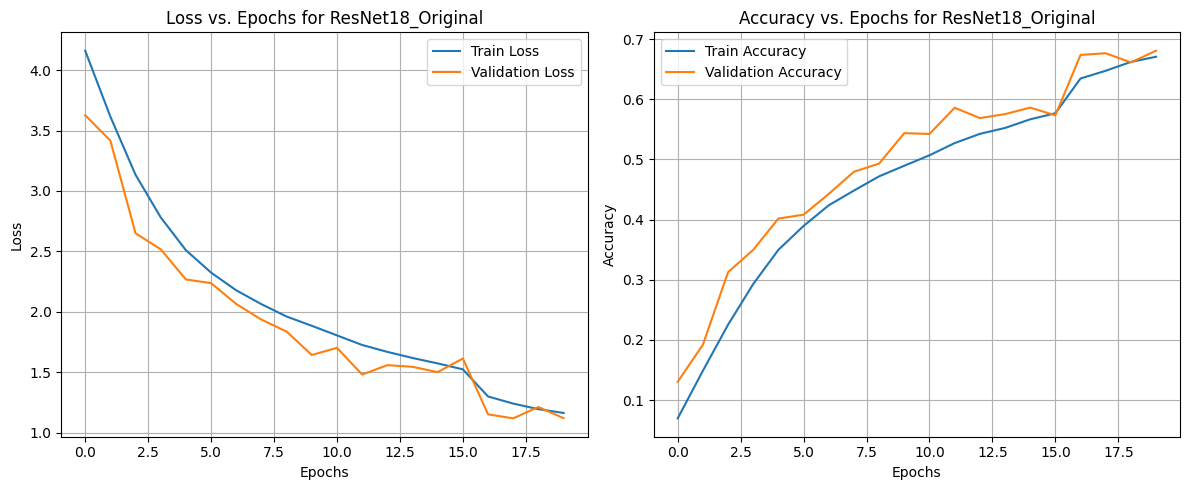

Loading best model weights from /content/drive/MyDrive/Colab Notebooks/HWe/best_ResNet18_Original.pth


In [ ]:
# Applying Data Augmentation
model_original = create_resnet18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model_original.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_original = optim.lr_scheduler.ReduceLROnPlateau(optimizer_original, 'min', patience=3, factor=0.5)

best_model_original, history_original = train_model(
    model=model_original,
    model_name="ResNet18_Original",
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_original,
    scheduler=scheduler_original,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

In [ ]:
# Load Trained Model
best_model_original = create_resnet18_cifar()
best_model_original.load_state_dict(torch.load(base_path + "/best_ResNet18_Original.pth", map_location=device))

# Load Trained Model
best_model_noisy = create_resnet18_cifar()
best_model_noisy.load_state_dict(torch.load(base_path + "/best_ResNet18_Noisy.pth", map_location=device))

<All keys matched successfully>

In [ ]:
acc_original, _ = evaluate_model(best_model_original, test_loader, "ResNet18_Original")

print(f"Final Test Accuracy (trained on original data): {100 * acc_original:.2f}%")


--- Evaluating ResNet18_Original on the Test Set ---
Test Loss: 1.1395
Test Accuracy: 67.14%
Final Test Accuracy (trained on original data): 67.14%


In [ ]:
input_shape = (3, 32, 32)
summary(best_model_original, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

#### Training model on noisy dataset


--- Starting Training for: ResNet18_Noisy ---


Epoch 1/20 | Train Loss: 3.6662, Train Acc: 0.1396 | Val Loss: 3.4458, Val Acc: 0.1816


Epoch 2/20 | Train Loss: 2.9940, Train Acc: 0.2555 | Val Loss: 3.0493, Val Acc: 0.2478


Epoch 3/20 | Train Loss: 2.6481, Train Acc: 0.3217 | Val Loss: 2.9631, Val Acc: 0.2912


Epoch 4/20 | Train Loss: 2.4148, Train Acc: 0.3722 | Val Loss: 2.5810, Val Acc: 0.3458


Epoch 5/20 | Train Loss: 2.2393, Train Acc: 0.4105 | Val Loss: 2.5422, Val Acc: 0.3498


Epoch 6/20 | Train Loss: 2.0923, Train Acc: 0.4417 | Val Loss: 2.5240, Val Acc: 0.3586


Epoch 7/20 | Train Loss: 1.9683, Train Acc: 0.4662 | Val Loss: 2.4547, Val Acc: 0.3732


Epoch 8/20 | Train Loss: 1.8586, Train Acc: 0.4953 | Val Loss: 2.5341, Val Acc: 0.3632


Epoch 9/20 | Train Loss: 1.7492, Train Acc: 0.5209 | Val Loss: 2.3936, Val Acc: 0.3880


Epoch 10/20 | Train Loss: 1.6381, Train Acc: 0.5465 | Val Loss: 2.4108, Val Acc: 0.3864


Epoch 11/20 | Train Loss: 1.5220, Train Acc: 0.5737 | Val Loss: 2.4909, Val Acc: 0.3856


Epoch 12/20 | Train Loss: 1.4164, Train Acc: 0.6015 | Val Loss: 2.3790, Val Acc: 0.4028


Epoch 13/20 | Train Loss: 1.3100, Train Acc: 0.6251 | Val Loss: 2.4486, Val Acc: 0.4006


Epoch 14/20 | Train Loss: 1.1962, Train Acc: 0.6583 | Val Loss: 2.5394, Val Acc: 0.3972


Epoch 15/20 | Train Loss: 1.0709, Train Acc: 0.6882 | Val Loss: 2.7466, Val Acc: 0.3740


Epoch 16/20 | Train Loss: 0.9657, Train Acc: 0.7175 | Val Loss: 2.6403, Val Acc: 0.3964


Epoch 17/20 | Train Loss: 0.5665, Train Acc: 0.8455 | Val Loss: 2.2578, Val Acc: 0.4560


Epoch 18/20 | Train Loss: 0.4241, Train Acc: 0.8918 | Val Loss: 2.2670, Val Acc: 0.4678


Epoch 19/20 | Train Loss: 0.3581, Train Acc: 0.9098 | Val Loss: 2.2948, Val Acc: 0.4640


Epoch 20/20 | Train Loss: 0.3133, Train Acc: 0.9243 | Val Loss: 2.3326, Val Acc: 0.4584


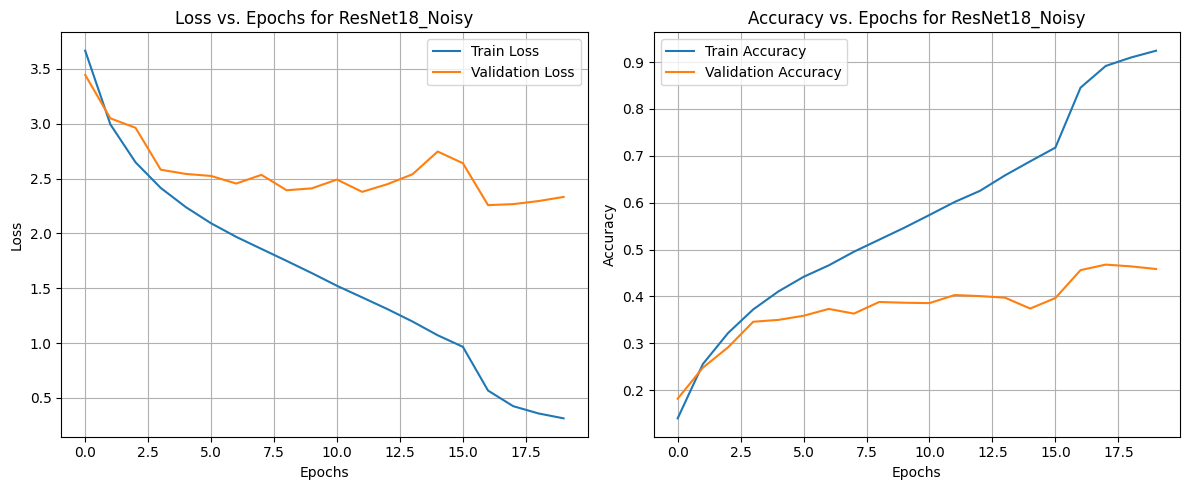

Loading best model weights from /content/drive/MyDrive/Colab Notebooks/HWe/best_ResNet18_Noisy.pth


In [ ]:
# Without Data Augmentation
model_noisy = create_resnet18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer_noisy = optim.Adam(model_noisy.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_noisy = optim.lr_scheduler.ReduceLROnPlateau(optimizer_noisy, 'min', patience=3, factor=0.1)

best_model_noisy, history_noisy = train_model(
    model=model_noisy,
    model_name="ResNet18_Noisy",
    train_loader=train_loader_noisy,
    val_loader=val_loader_noisy,
    optimizer=optimizer_noisy,
    scheduler=scheduler_noisy,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


--- Starting Training for: ResNet18_Noisy ---


Epoch 1/20 | Train Loss: 4.1942, Train Acc: 0.0680 | Val Loss: 4.3117, Val Acc: 0.0832


Epoch 2/20 | Train Loss: 3.7879, Train Acc: 0.1215 | Val Loss: 4.3298, Val Acc: 0.1174


Epoch 3/20 | Train Loss: 3.5327, Train Acc: 0.1700 | Val Loss: 3.6686, Val Acc: 0.1828


Epoch 4/20 | Train Loss: 3.3540, Train Acc: 0.1968 | Val Loss: 4.4830, Val Acc: 0.1464


Epoch 5/20 | Train Loss: 3.2114, Train Acc: 0.2248 | Val Loss: 3.7249, Val Acc: 0.1906


Epoch 6/20 | Train Loss: 3.1077, Train Acc: 0.2458 | Val Loss: 3.0720, Val Acc: 0.2644


Epoch 7/20 | Train Loss: 3.0304, Train Acc: 0.2609 | Val Loss: 3.0077, Val Acc: 0.2852


Epoch 8/20 | Train Loss: 2.9612, Train Acc: 0.2715 | Val Loss: 3.0509, Val Acc: 0.2766


Epoch 9/20 | Train Loss: 2.9049, Train Acc: 0.2811 | Val Loss: 3.1393, Val Acc: 0.2708


Epoch 10/20 | Train Loss: 2.8467, Train Acc: 0.2976 | Val Loss: 3.3237, Val Acc: 0.2562


Epoch 11/20 | Train Loss: 2.7950, Train Acc: 0.3072 | Val Loss: 3.0081, Val Acc: 0.3016


Epoch 12/20 | Train Loss: 2.6092, Train Acc: 0.3467 | Val Loss: 2.8031, Val Acc: 0.3414


Epoch 13/20 | Train Loss: 2.5406, Train Acc: 0.3580 | Val Loss: 3.0074, Val Acc: 0.3118


Epoch 14/20 | Train Loss: 2.5102, Train Acc: 0.3665 | Val Loss: 2.9833, Val Acc: 0.3178


Epoch 15/20 | Train Loss: 2.4826, Train Acc: 0.3724 | Val Loss: 2.6749, Val Acc: 0.3518


Epoch 16/20 | Train Loss: 2.4516, Train Acc: 0.3772 | Val Loss: 2.5737, Val Acc: 0.3682


Epoch 17/20 | Train Loss: 2.4374, Train Acc: 0.3786 | Val Loss: 2.7421, Val Acc: 0.3524


Epoch 18/20 | Train Loss: 2.3973, Train Acc: 0.3898 | Val Loss: 2.7572, Val Acc: 0.3556


Epoch 19/20 | Train Loss: 2.3681, Train Acc: 0.3960 | Val Loss: 2.8588, Val Acc: 0.3464


Epoch 20/20 | Train Loss: 2.3668, Train Acc: 0.3977 | Val Loss: 2.5787, Val Acc: 0.3810


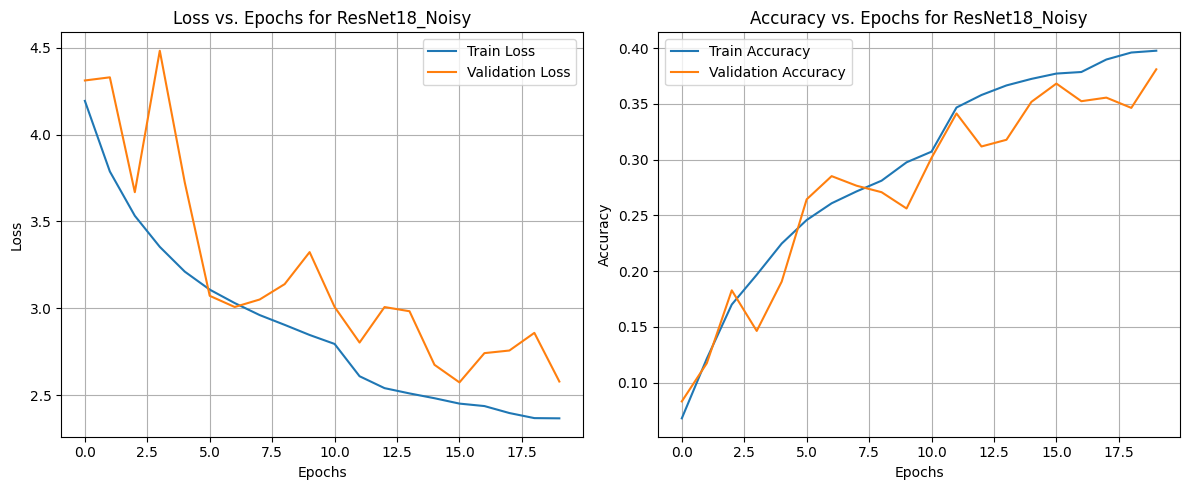

Loading best model weights from /content/drive/MyDrive/Colab Notebooks/HWe/best_ResNet18_Noisy.pth


In [ ]:
# Applying Data Augmentation
model_noisy = create_resnet18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer_noisy = optim.Adam(model_noisy.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_noisy = optim.lr_scheduler.ReduceLROnPlateau(optimizer_noisy, 'min', patience=3, factor=0.5)

best_model_noisy, history_noisy = train_model(
    model=model_noisy,
    model_name="ResNet18_Noisy",
    train_loader=train_loader_noisy,
    val_loader=val_loader_noisy,
    optimizer=optimizer_noisy,
    scheduler=scheduler_noisy,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

### 1-5: Evaluation and Comparison

In [ ]:
acc_original, _ = evaluate_model(best_model_original, test_loader, "ResNet18_Original")

acc_noisy, _ = evaluate_model(best_model_noisy, test_loader, "ResNet18_Noisy")

print("\n--- Comparison ---")
print(f"Final Test Accuracy (trained on original data): {100 * acc_original:.2f}%")
print(f"Final Test Accuracy (trained on noisy data):  {100 * acc_noisy:.2f}%")


--- Evaluating ResNet18_Original on the Test Set ---
Test Loss: 1.1395
Test Accuracy: 67.14%

--- Evaluating ResNet18_Noisy on the Test Set ---
Test Loss: 2.5810
Test Accuracy: 37.04%

--- Comparison ---
Final Test Accuracy (trained on original data): 67.14%
Final Test Accuracy (trained on noisy data):  37.04%


In [ ]:
def plot_confusion_matrix(model, dataloader, model_name):
    print(f"\n--- Generating Confusion Matrix for {model_name} ---")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Getting Predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()
    return cm


--- Generating Confusion Matrix for ResNet18_Original_Augmented ---


Getting Predictions: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


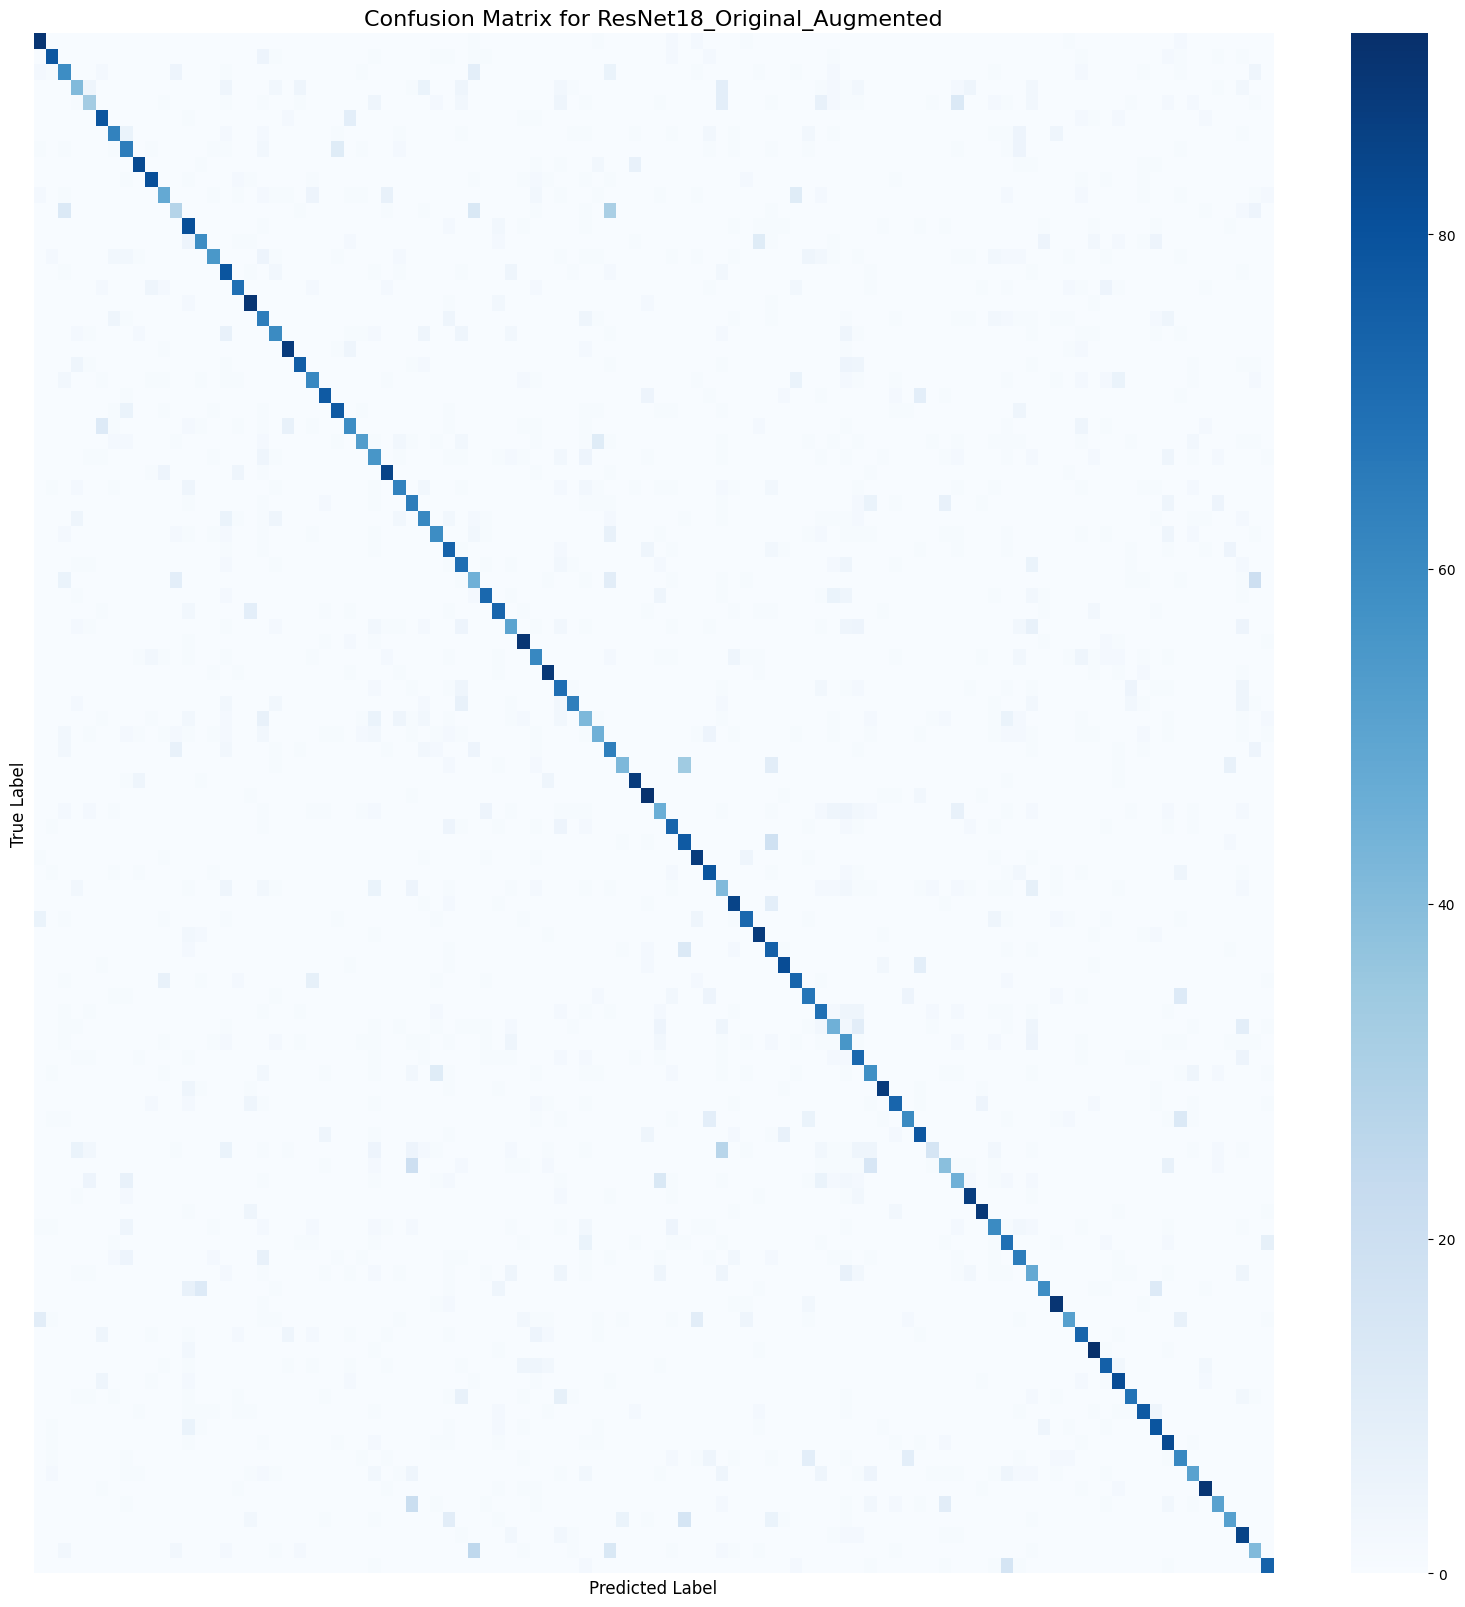


--- Generating Confusion Matrix for ResNet18_Noisy_Augmented ---


Getting Predictions: 100%|██████████| 79/79 [00:04<00:00, 17.50it/s]


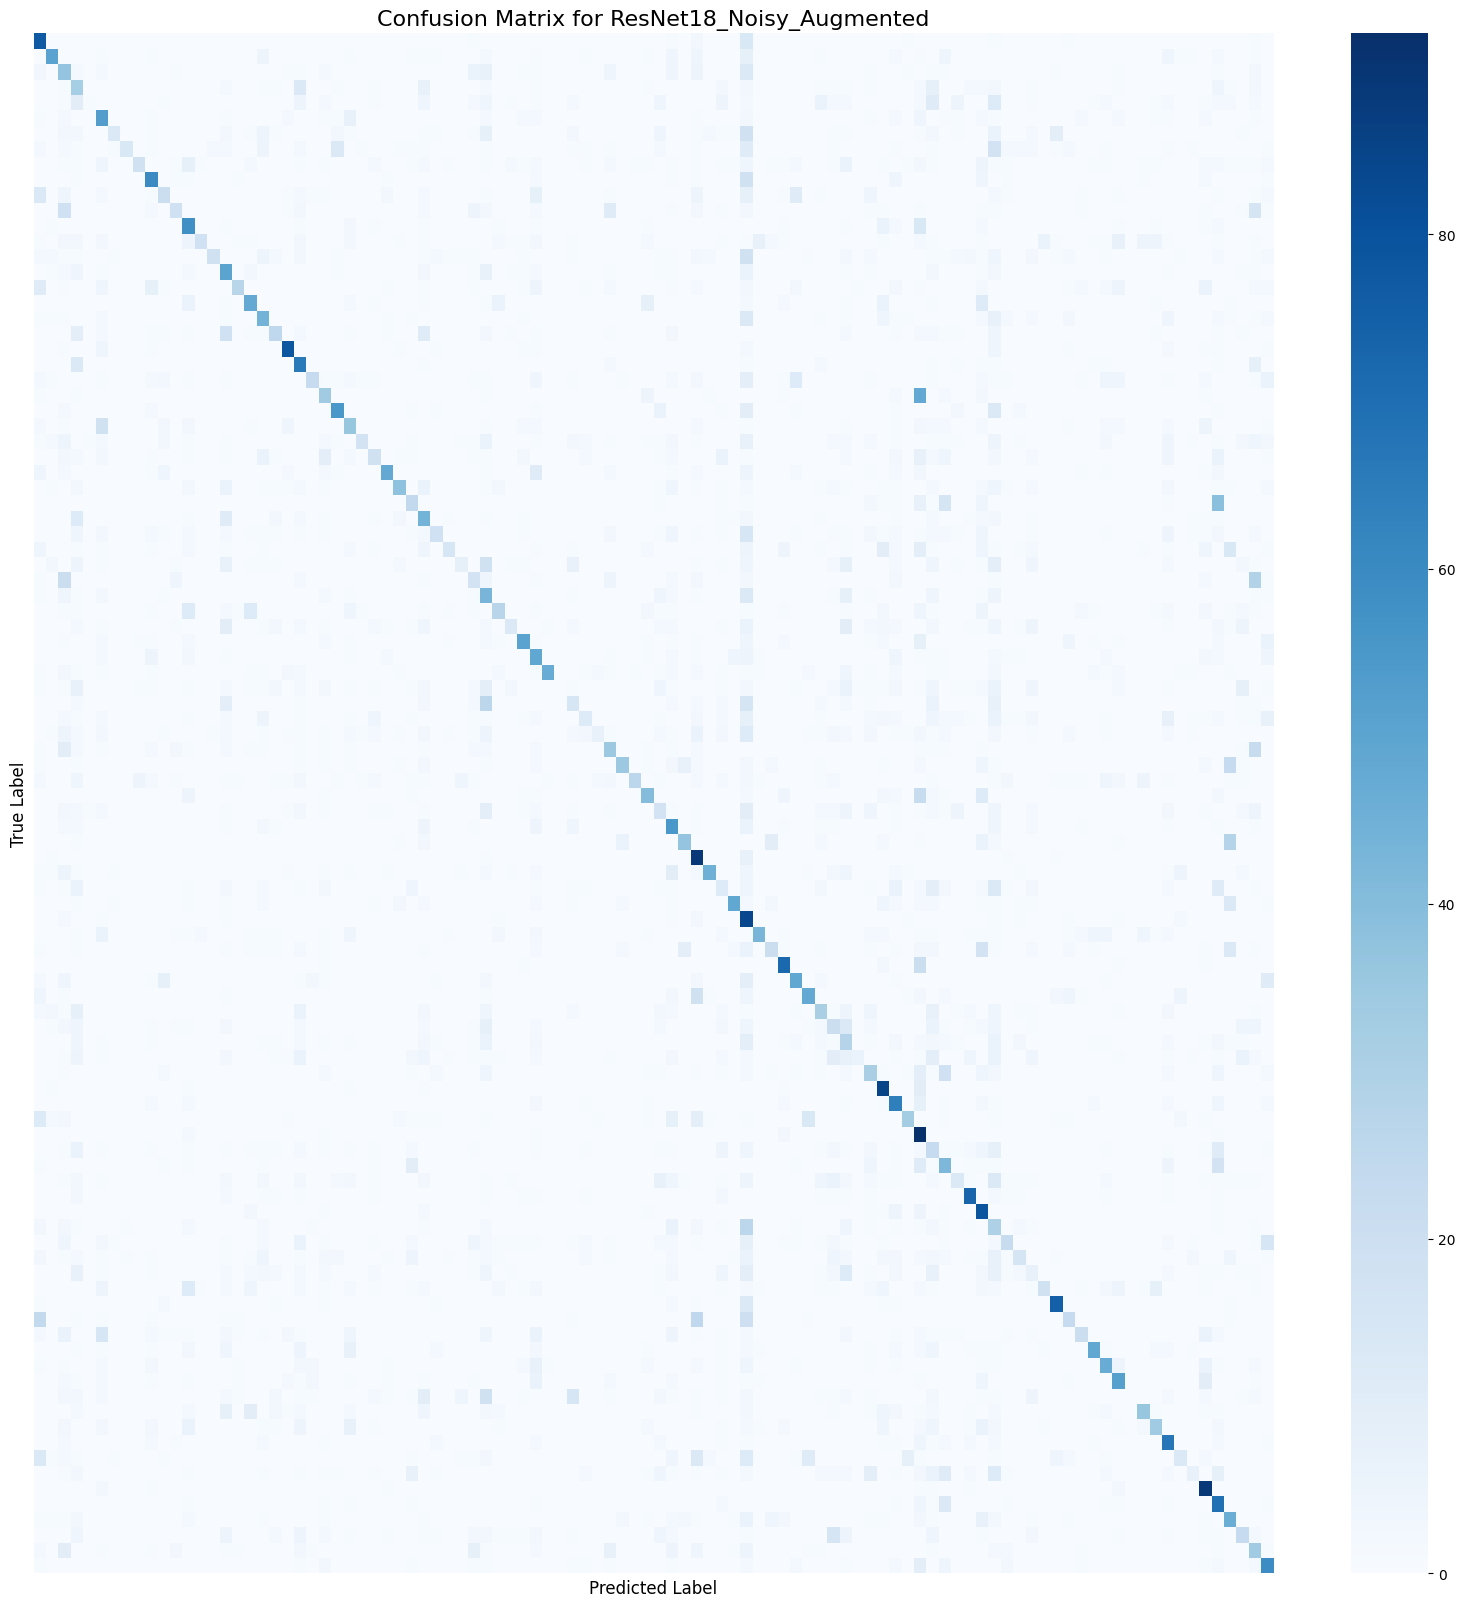

In [ ]:
cm_original = plot_confusion_matrix(best_model_original, test_loader, "ResNet18_Original_Augmented")
cm_noisy = plot_confusion_matrix(best_model_noisy, test_loader, "ResNet18_Noisy_Augmented")

In [ ]:
class_names = trainset.classes

predictions_original = np.sum(cm_original, axis=0)
most_predicted_idx_original = np.argmax(predictions_original)
most_predicted_class_original = class_names[most_predicted_idx_original]
prediction_count_original = predictions_original[most_predicted_idx_original]

print(f"--- Model Trained on Original Data ---")
print(f"The class predicted most often is: '{most_predicted_class_original}'")
print(f"It was predicted {int(prediction_count_original)} times in total.")
print("\n" + "-"*40)


predictions_noisy = np.sum(cm_noisy, axis=0)
most_predicted_idx_noisy = np.argmax(predictions_noisy)
most_predicted_class_noisy = class_names[most_predicted_idx_noisy]
prediction_count_noisy = predictions_noisy[most_predicted_idx_noisy]

print(f"--- Model Trained on Noisy Data ---")
print(f"The class predicted most often is: '{most_predicted_class_noisy}'")
print(f"It was predicted {int(prediction_count_noisy)} times in total.")

--- Model Trained on Original Data ---
The class predicted most often is: 'man'
It was predicted 149 times in total.

----------------------------------------
--- Model Trained on Noisy Data ---
The class predicted most often is: 'pear'
It was predicted 588 times in total.


In [ ]:
def analyze_and_plot_per_class_accuracy(cm_original, cm_noisy, class_names):

    print("\n--- Analyzing Per-Class Accuracy ---")

    # Calculate per-class accuracy: diagonal / row_sum
    per_class_acc_original = cm_original.diagonal() / cm_original.sum(axis=1)
    per_class_acc_noisy = cm_noisy.diagonal() / cm_noisy.sum(axis=1)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Class': class_names,
        'Original Model Accuracy': per_class_acc_original,
        'Noisy Model Accuracy': per_class_acc_noisy
    })
    df = df.sort_values(by='Original Model Accuracy', ascending=False)

    plt.figure(figsize=(20, 10))
    df.plot(x='Class', y=['Original Model Accuracy', 'Noisy Model Accuracy'], kind='bar', figsize=(25, 8))
    plt.title('Per-Class Accuracy Comparison', fontsize=16)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Print classes with the largest performance drop
    df['drop'] = df['Original Model Accuracy'] - df['Noisy Model Accuracy']
    print("\nTop 10 Classes with Largest Performance Drop:")
    print(df.sort_values(by='drop', ascending=False).head(10))

In [ ]:
def analyze_super_class_accuracy(model, dataloader, model_name, fine_to_coarse_map):
    print(f"\n--- Analyzing Super-Class Accuracy for {model_name} ---")
    model.eval()
    correct_super = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Super-Class Eval for {model_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert fine-grained labels/preds to coarse-grained
            labels_coarse = torch.tensor([fine_to_coarse_map[l.item()] for l in labels]).to(device)
            preds_coarse = torch.tensor([fine_to_coarse_map[p.item()] for p in preds]).to(device)

            total += labels.size(0)
            correct_super += (preds_coarse == labels_coarse).sum().item()

    super_acc = correct_super / total
    print(f"Super-Class Accuracy for {model_name}: {100 * super_acc:.2f}%")
    return super_acc

In [ ]:
## Map 100 classes to 20 Super-classes
fine_to_coarse_map = [
    4, 1, 14, 8, 0, 6, 7, 7, 18, 3, 3, 14, 9, 18, 7, 11, 3, 9, 7, 11, 6, 11, 5, 10, 7, 6, 13, 15, 3, 15,
    0, 11, 1, 10, 12, 14, 16, 9, 11, 5, 5, 19, 8, 8, 15, 13, 14, 17, 18, 10, 16, 4, 17, 4, 2, 0, 17, 4,
    18, 17, 10, 3, 2, 12, 12, 16, 12, 1, 9, 19, 2, 10, 0, 1, 16, 12, 9, 13, 15, 13, 16, 19, 2, 4, 6, 19,
    5, 5, 8, 19, 18, 1, 2, 15, 6, 0, 17, 8, 14, 13
]

class_names = testset.classes


--- Analyzing Per-Class Accuracy ---


<Figure size 2000x1000 with 0 Axes>

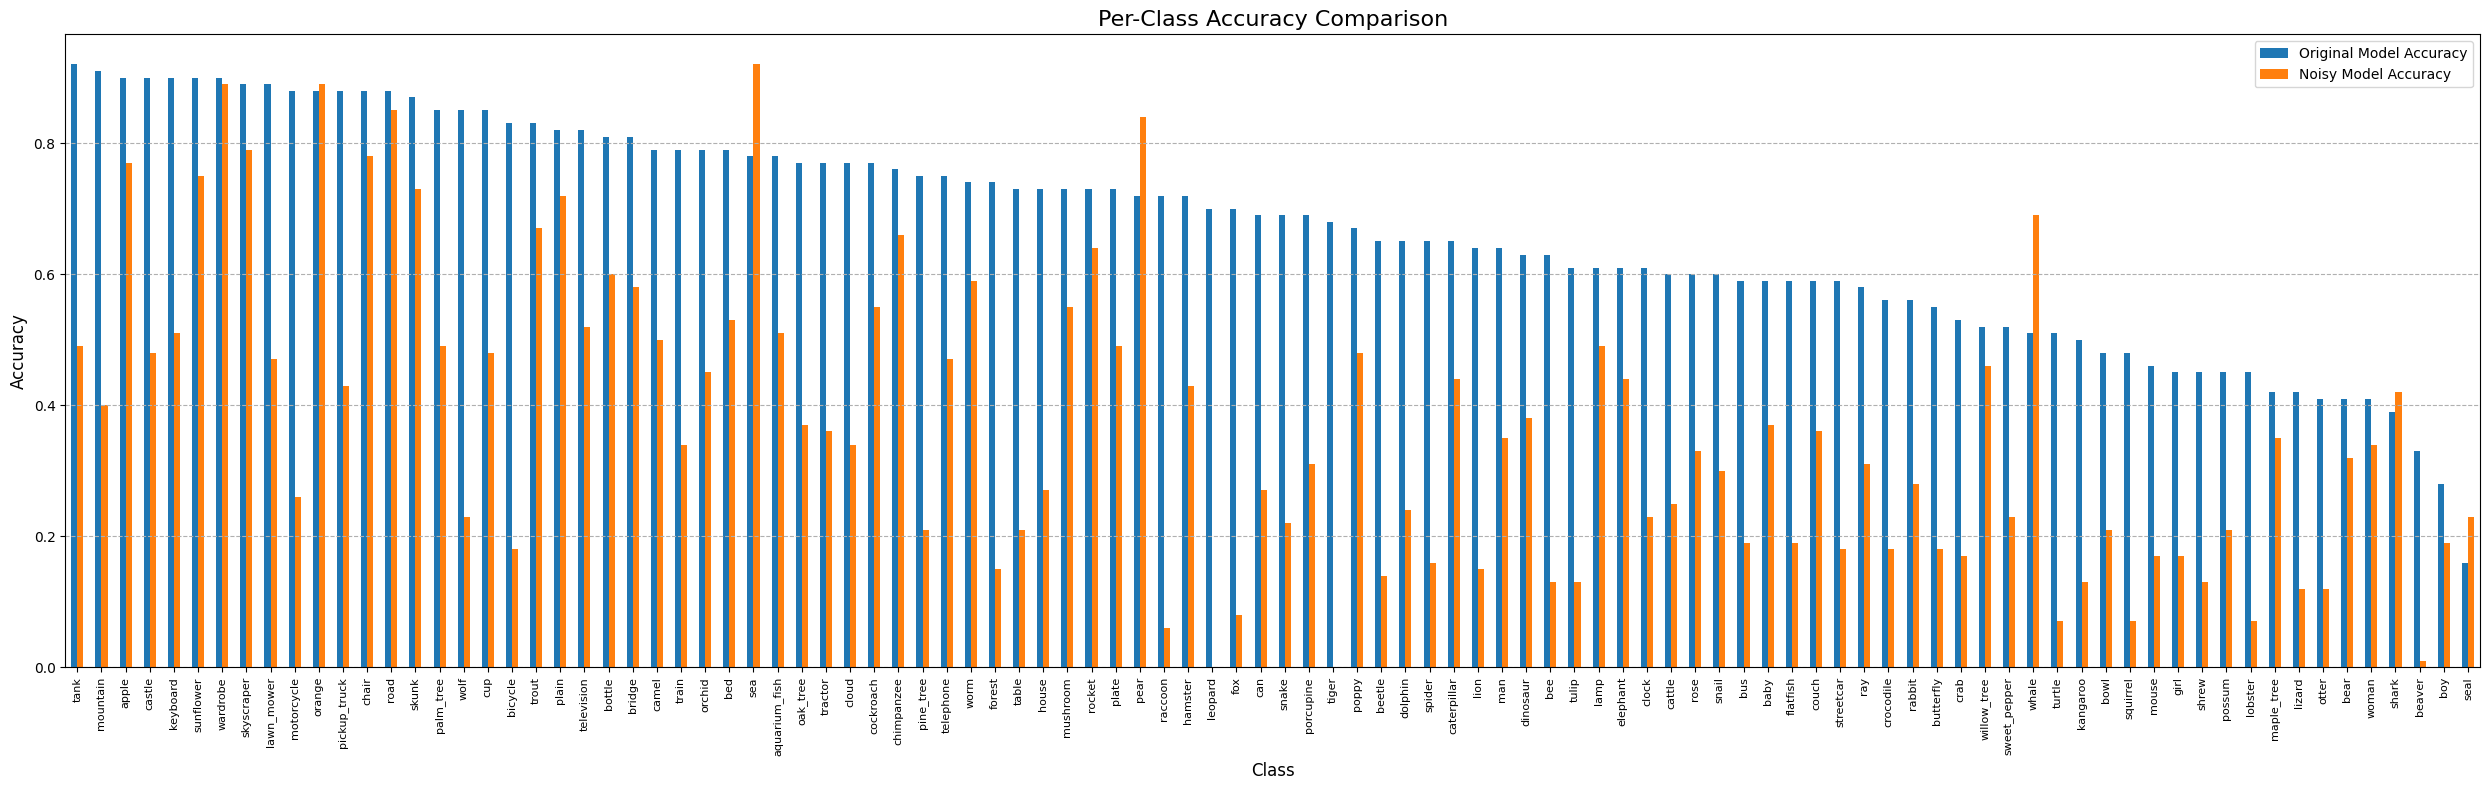


Top 10 Classes with Largest Performance Drop:
         Class  Original Model Accuracy  Noisy Model Accuracy  drop
42     leopard                     0.70                  0.00  0.70
88       tiger                     0.68                  0.00  0.68
66     raccoon                     0.72                  0.06  0.66
8      bicycle                     0.83                  0.18  0.65
34         fox                     0.70                  0.08  0.62
48  motorcycle                     0.88                  0.26  0.62
97        wolf                     0.85                  0.23  0.62
33      forest                     0.74                  0.15  0.59
59   pine_tree                     0.75                  0.21  0.54
84       table                     0.73                  0.21  0.52


In [ ]:
analyze_and_plot_per_class_accuracy(cm_original, cm_noisy, class_names)

In [ ]:
super_acc_original = analyze_super_class_accuracy(best_model_original, test_loader, "ResNet18_Original_Augmented", fine_to_coarse_map)
super_acc_noisy = analyze_super_class_accuracy(best_model_noisy, test_loader, "ResNet18_Noisy_Augmented", fine_to_coarse_map)

print("\n--- Super-Class Comparison Summary ---")
print(f"Super-Class Accuracy (trained on original augmented data): {100 * super_acc_original:.2f}%")
print(f"Super-Class Accuracy (trained on noisy augmented data):  {100 * super_acc_noisy:.2f}%")
print("="*60)


--- Analyzing Super-Class Accuracy for ResNet18_Original_Augmented ---


Super-Class Eval for ResNet18_Original_Augmented: 100%|██████████| 79/79 [00:05<00:00, 14.64it/s]


Super-Class Accuracy for ResNet18_Original_Augmented: 78.86%

--- Analyzing Super-Class Accuracy for ResNet18_Noisy_Augmented ---


Super-Class Eval for ResNet18_Noisy_Augmented: 100%|██████████| 79/79 [00:04<00:00, 16.66it/s]

Super-Class Accuracy for ResNet18_Noisy_Augmented: 50.41%

--- Super-Class Comparison Summary ---
Super-Class Accuracy (trained on original augmented data): 78.86%
Super-Class Accuracy (trained on noisy augmented data):  50.41%


## 2: Transfer Learning with ViT on Flowers-102 Dataset

### 2-1: Load vit_base_patch16_224 Model

In [ ]:
model_checkpoint = 'google/vit-base-patch16-224'

processor_vit = ViTImageProcessor.from_pretrained(model_checkpoint)

num_classes = 102

model_vit = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

print("\nNew classifier layer:")
print(model_vit.classifier)

# Move the model to the selected device
model_vit = model_vit.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



New classifier layer:
Linear(in_features=768, out_features=102, bias=True)


In [ ]:
total_params = sum(p.numel() for p in model_vit.parameters())
trainable_params = sum(p.numel() for p in model_vit.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Total Parameters: 85,877,094
Trainable Parameters: 85,877,094


#### Load Flowers-102 Dataset

In [ ]:
data_path = base_path +"/flowers102"

train_dataset = torchvision.datasets.Flowers102(root=data_path, split='train', download=True)

val_dataset = torchvision.datasets.Flowers102(root=data_path, split='val', download=True)

test_dataset = torchvision.datasets.Flowers102(root=data_path, split='test', download=True)

In [ ]:
print(f"Number of training images:   {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images:       {len(test_dataset)}")

Number of training images:   1020
Number of validation images: 1020
Number of test images:       6149


#### Data Loaders

In [ ]:
def collate_fn(batch):

    images = [item[0] for item in batch]

    labels = torch.tensor([item[1] for item in batch])
    inputs = processor_vit(images, return_tensors='pt')
    inputs['labels'] = labels
    return inputs

In [ ]:
batch_size = 64
train_loader_vit = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader_vit = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader_vit = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

### 2-2: Fine-tune ViT model

In [ ]:
model_save_path = base_path + "/vit_flowers102"

In [ ]:
def train_vit_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, model_name):

    print(f"\n--- Starting Training for: {model_name} ---")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_path = os.path.join(model_save_path, f"best_model_{model_name}.pth")

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in train_pbar:
            inputs = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_train_loss += loss.item() * inputs['labels'].size(0)
            _, predicted = torch.max(logits, 1)
            total_train += inputs['labels'].size(0)
            correct_train += (predicted == inputs['labels']).sum().item()
            train_pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{correct_train / total_train:.4f}"})

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for batch in val_pbar:
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits
                running_val_loss += loss.item() * inputs['labels'].size(0)
                _, predicted = torch.max(logits, 1)
                total_val += inputs['labels'].size(0)
                correct_val += (predicted == inputs['labels']).sum().item()
                val_pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{correct_val / total_val:.4f}"})

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | LR: {current_lr:.2e}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss vs. Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy vs. Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Loading best model from {best_model_path} for final evaluation.")
    model.load_state_dict(torch.load(best_model_path))
    return model

In [ ]:
def evaluate_vit_model(model, test_loader, model_name):
    print(f"\n--- Evaluating {model_name} on Test Set ---")
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Testing {model_name}"):
            labels = batch['labels'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = correct_test / total_test
    print(f"\nFinal Test Accuracy for {model_name}: {100 * test_acc:.2f}%")
    return test_acc

In [ ]:
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

In [ ]:
optimizer = AdamW(model_vit.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
num_training_steps = len(train_loader_vit) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


--- Starting Fine-Tuning ---


Epoch 1/5 [Val]: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it, Loss=4.1505, Acc=0.1490]


Epoch 1/5 | Train Loss: 4.5946, Train Acc: 0.0284 | Val Loss: 4.1617, Val Acc: 0.1490 | LR: 4.44e-05
New best model saved to /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model.pth with validation accuracy: 0.1490


Epoch 2/5 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it, Loss=3.4349, Acc=0.5157]


Epoch 2/5 | Train Loss: 3.5983, Train Acc: 0.4676 | Val Loss: 3.4679, Val Acc: 0.5157 | LR: 3.33e-05
New best model saved to /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model.pth with validation accuracy: 0.5157


Epoch 3/5 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it, Loss=2.9554, Acc=0.7382]


Epoch 3/5 | Train Loss: 2.7715, Train Acc: 0.8627 | Val Loss: 2.9682, Val Acc: 0.7382 | LR: 2.22e-05
New best model saved to /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model.pth with validation accuracy: 0.7382


Epoch 4/5 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, Loss=2.5968, Acc=0.8176]


Epoch 4/5 | Train Loss: 2.2210, Train Acc: 0.9618 | Val Loss: 2.6818, Val Acc: 0.8176 | LR: 1.11e-05
New best model saved to /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model.pth with validation accuracy: 0.8176


Epoch 5/5 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it, Loss=2.4920, Acc=0.8480]


Epoch 5/5 | Train Loss: 1.9324, Train Acc: 0.9843 | Val Loss: 2.5848, Val Acc: 0.8480 | LR: 0.00e+00
New best model saved to /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model.pth with validation accuracy: 0.8480


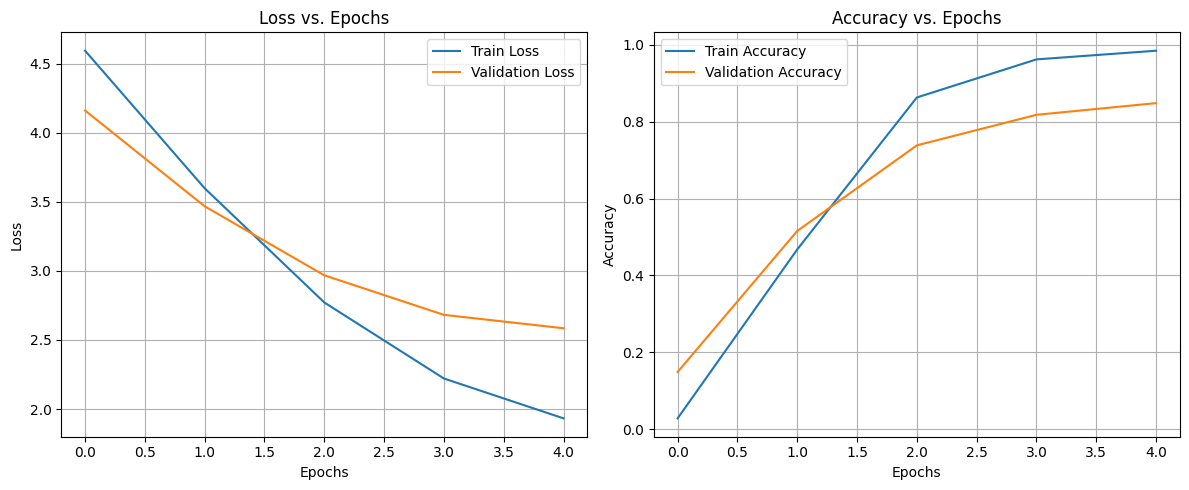

In [ ]:
trained_vit_model = train_vit_model(model_vit, train_loader_vit, val_loader_vit, optimizer, scheduler, NUM_EPOCHS, "ViT_FineTuned")

In [ ]:
acc_finetune = evaluate_vit_model(trained_vit_model, test_loader_vit, "ViT_FineTuned")


--- Evaluating on Test Set ---


Testing: 100%|██████████| 97/97 [02:09<00:00,  1.33s/it]


Final Test Accuracy: 83.18%


0.8318425760286225

### 2-3: Learn model from scratch

In [ ]:
config = ViTConfig.from_pretrained(model_checkpoint, num_labels=num_classes)
model_vit_scratch = ViTForImageClassification(config).to(device)

In [ ]:
NUM_EPOCHS_SCRATCH = 10
LEARNING_RATE_SCRATCH = 5e-5
WEIGHT_DECAY_SCRATCH = 0.01

In [ ]:
optimizer_scratch = AdamW(model_vit_scratch.parameters(), lr=LEARNING_RATE_SCRATCH, weight_decay=WEIGHT_DECAY_SCRATCH)
num_training_steps_scratch = len(train_loader_vit) * NUM_EPOCHS_SCRATCH
num_warmup_steps_scratch = int(0.1 * num_training_steps_scratch)
scheduler_scratch = get_linear_schedule_with_warmup(optimizer_scratch, num_warmup_steps=num_warmup_steps_scratch, num_training_steps=num_training_steps_scratch)


--- Starting Training for: ViT_From_Scratch ---


Epoch 1/10 [Val]: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it, Loss=4.1338, Acc=0.0480]


Epoch 1/10 | Train Loss: 4.6087, Train Acc: 0.0245 | Val Loss: 4.2346, Val Acc: 0.0480 | LR: 5.00e-05


Epoch 2/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it, Loss=3.8340, Acc=0.1010]


Epoch 2/10 | Train Loss: 4.0084, Train Acc: 0.0745 | Val Loss: 3.8441, Val Acc: 0.1010 | LR: 4.44e-05


Epoch 3/10 [Val]: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it, Loss=3.7614, Acc=0.1598]


Epoch 3/10 | Train Loss: 3.5332, Train Acc: 0.1461 | Val Loss: 3.5454, Val Acc: 0.1598 | LR: 3.89e-05


Epoch 4/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it, Loss=3.4907, Acc=0.1931]


Epoch 4/10 | Train Loss: 3.1629, Train Acc: 0.2069 | Val Loss: 3.4093, Val Acc: 0.1931 | LR: 3.33e-05


Epoch 5/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it, Loss=3.2938, Acc=0.2225]


Epoch 5/10 | Train Loss: 2.8343, Train Acc: 0.2745 | Val Loss: 3.2177, Val Acc: 0.2225 | LR: 2.78e-05


Epoch 6/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it, Loss=3.0918, Acc=0.2598]


Epoch 6/10 | Train Loss: 2.5024, Train Acc: 0.3490 | Val Loss: 3.1132, Val Acc: 0.2598 | LR: 2.22e-05


Epoch 7/10 [Val]: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it, Loss=3.2675, Acc=0.2784]


Epoch 7/10 | Train Loss: 2.1949, Train Acc: 0.4500 | Val Loss: 3.0398, Val Acc: 0.2784 | LR: 1.67e-05


Epoch 8/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it, Loss=2.9780, Acc=0.2912]


Epoch 8/10 | Train Loss: 1.9164, Train Acc: 0.5275 | Val Loss: 2.9854, Val Acc: 0.2912 | LR: 1.11e-05


Epoch 9/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it, Loss=3.1280, Acc=0.3020]


Epoch 9/10 | Train Loss: 1.6739, Train Acc: 0.6108 | Val Loss: 2.9497, Val Acc: 0.3020 | LR: 5.56e-06


Epoch 10/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, Loss=3.1125, Acc=0.2990]


Epoch 10/10 | Train Loss: 1.4890, Train Acc: 0.6824 | Val Loss: 2.9445, Val Acc: 0.2990 | LR: 0.00e+00


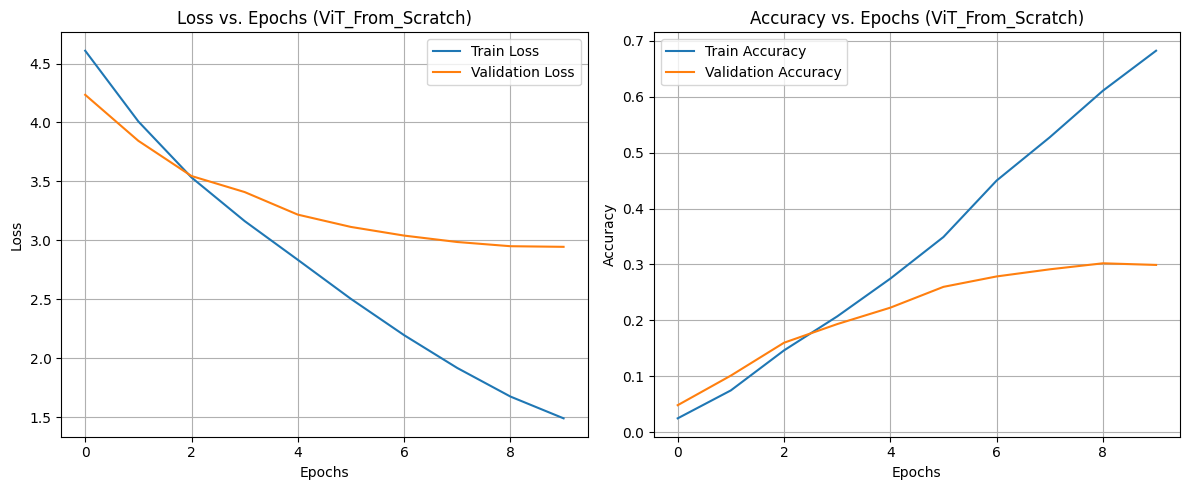

Loading best model from /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model_ViT_From_Scratch.pth for final evaluation.


In [ ]:
best_model_scratch = train_vit_model(model_vit_scratch, train_loader_vit, val_loader_vit, optimizer_scratch, scheduler_scratch, NUM_EPOCHS_SCRATCH, "ViT_From_Scratch")

In [ ]:
acc_scratch = evaluate_vit_model(best_model_scratch, test_loader_vit, "ViT_From_Scratch")


--- Evaluating ViT_From_Scratch on Test Set ---


Testing ViT_From_Scratch: 100%|██████████| 97/97 [02:17<00:00,  1.42s/it]

Final Test Accuracy for ViT_From_Scratch: 25.87%


In [ ]:
NUM_EPOCHS_SCRATCH = 10
LEARNING_RATE_SCRATCH = 5e-4
WEIGHT_DECAY_SCRATCH = 0.01


--- Starting Training for: ViT_From_Scratch_V2 ---


Epoch 1/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it, Loss=4.0369, Acc=0.0539]


Epoch 1/10 | Train Loss: 4.6635, Train Acc: 0.0176 | Val Loss: 4.2712, Val Acc: 0.0539 | LR: 5.00e-04


Epoch 2/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it, Loss=3.7872, Acc=0.0853]


Epoch 2/10 | Train Loss: 4.0397, Train Acc: 0.0392 | Val Loss: 3.7840, Val Acc: 0.0853 | LR: 4.44e-04


Epoch 3/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it, Loss=3.6441, Acc=0.1353]


Epoch 3/10 | Train Loss: 3.6634, Train Acc: 0.0873 | Val Loss: 3.5894, Val Acc: 0.1353 | LR: 3.89e-04


Epoch 4/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it, Loss=3.4670, Acc=0.1363]


Epoch 4/10 | Train Loss: 3.4485, Train Acc: 0.1373 | Val Loss: 3.4882, Val Acc: 0.1363 | LR: 3.33e-04


Epoch 5/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, Loss=3.3264, Acc=0.1559]


Epoch 5/10 | Train Loss: 3.2113, Train Acc: 0.1598 | Val Loss: 3.3815, Val Acc: 0.1559 | LR: 2.78e-04


Epoch 6/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it, Loss=3.2978, Acc=0.1833]


Epoch 6/10 | Train Loss: 3.0229, Train Acc: 0.2147 | Val Loss: 3.2511, Val Acc: 0.1833 | LR: 2.22e-04


Epoch 7/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, Loss=3.0886, Acc=0.2010]


Epoch 7/10 | Train Loss: 2.8282, Train Acc: 0.2314 | Val Loss: 3.1800, Val Acc: 0.2010 | LR: 1.67e-04


Epoch 8/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it, Loss=3.0864, Acc=0.2118]


Epoch 8/10 | Train Loss: 2.6200, Train Acc: 0.2755 | Val Loss: 3.0935, Val Acc: 0.2118 | LR: 1.11e-04


Epoch 9/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it, Loss=3.2499, Acc=0.2294]


Epoch 9/10 | Train Loss: 2.3891, Train Acc: 0.3598 | Val Loss: 3.0922, Val Acc: 0.2294 | LR: 5.56e-05


Epoch 10/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, Loss=3.0944, Acc=0.2353]


Epoch 10/10 | Train Loss: 2.2096, Train Acc: 0.4245 | Val Loss: 3.0741, Val Acc: 0.2353 | LR: 0.00e+00


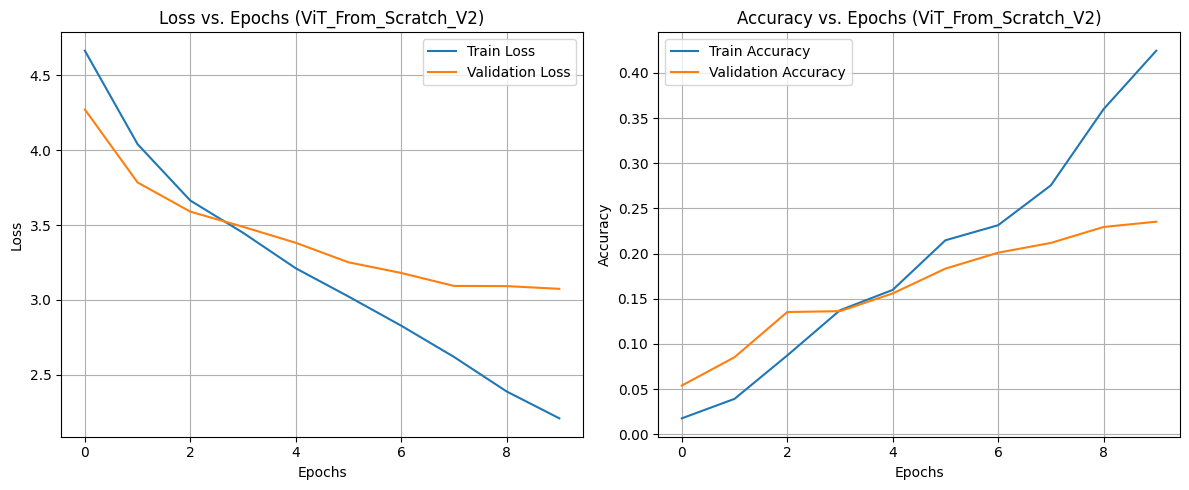

Loading best model from /content/drive/MyDrive/Colab Notebooks/HWe/vit_flowers102/best_model_ViT_From_Scratch_V2.pth for final evaluation.


In [ ]:
best_model_scratch = train_vit_model(model_vit_scratch, train_loader_vit, val_loader_vit, optimizer_scratch, scheduler_scratch, NUM_EPOCHS_SCRATCH, "ViT_From_Scratch_V2")

In [ ]:
acc_scratch = evaluate_vit_model(best_model_scratch, test_loader_vit, "ViT_From_Scratch")


--- Evaluating ViT_From_Scratch on Test Set ---


Testing ViT_From_Scratch: 100%|██████████| 97/97 [02:10<00:00,  1.35s/it]


Final Test Accuracy for ViT_From_Scratch: 20.57%


##3: Adversarial Attacks and Defending Against Them

### 3-1: PGD and FGSM Adversarial Attacks

#### Loading 4 models:

In [ ]:
# Load ResNet Models
ResNet18_Original = create_resnet18_cifar()
ResNet18_Original.load_state_dict(torch.load(base_path + "/best_ResNet18_Original.pth", map_location=device))
ResNet18_Original.to(device)

ResNet18_Noisy = create_resnet18_cifar()
ResNet18_Noisy.load_state_dict(torch.load(base_path + "/best_ResNet18_Noisy.pth", map_location=device))
ResNet18_Noisy.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
# Load Vit Models
ViT_FineTuned = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

fine_tuned_model_path = model_save_path + "/best_model_ViT_FineTuned.pth"
ViT_FineTuned.load_state_dict(torch.load(fine_tuned_model_path, map_location=device))
ViT_FineTuned.to(device)

config = ViTConfig.from_pretrained(model_checkpoint, num_labels=num_classes)
ViT_From_Scratch = ViTForImageClassification(config)

from_scratch_model_path = model_save_path + "/best_model_ViT_From_Scratch.pth"
ViT_From_Scratch.load_state_dict(torch.load(from_scratch_model_path, map_location=device))
ViT_From_Scratch.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

#### Applying Attacks:

In [ ]:
class ViTWrapper(nn.Module):

    def __init__(self, vit_model):
        super(ViTWrapper, self).__init__()
        self.vit_model = vit_model

    def forward(self, x):
        return self.vit_model(pixel_values=x).logits

In [ ]:
def evaluate_adversarial(model, dataloader, attack, model_type):

    model.eval()
    correct = 0
    total = 0

    pbar_desc = f"Evaluating {model_type.upper()} with {attack.__class__.__name__}"
    for batch in tqdm(dataloader, desc=pbar_desc):
        if model_type == 'vit':
            images, labels = batch['pixel_values'], batch['labels']
        else:
            images, labels = batch

        images, labels = images.to(device), labels.to(device)

        adv_images = attack(images, labels)

        with torch.no_grad():
            outputs = model(adv_images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
EPS_PGD = 0.08
ALPHA_PGD = 0.02
STEPS_PGD = 7
EPS_FGSM = 0.1

In [ ]:
results = []

model_configs = [
    {"name": "ResNet18 Original", "model": ResNet18_Original, "loader": test_loader, "type": "resnet"},
    {"name": "ResNet18 Noisy", "model": ResNet18_Noisy, "loader": test_loader, "type": "resnet"},
    {"name": "ViT Fine-Tuned", "model": ViT_FineTuned, "loader": test_loader_vit, "type": "vit"},
    {"name": "ViT From Scratch", "model": ViT_From_Scratch, "loader": test_loader_vit, "type": "vit"}
]

for config in model_configs:
    model_name = config["name"]
    model_to_attack = config["model"]
    loader = config["loader"]
    model_type = config["type"]

    if model_type == 'vit':
        model_to_attack = ViTWrapper(model_to_attack)

    print(f"\n--- Running attacks on {model_name} ---")

    # FGSM
    fgsm_attack = torchattacks.FGSM(model_to_attack, eps=EPS_FGSM)
    acc_fgsm = evaluate_adversarial(model_to_attack, loader, fgsm_attack, model_type)

    # PGD
    pgd_attack = torchattacks.PGD(model_to_attack, eps=EPS_PGD, alpha=ALPHA_PGD, steps=STEPS_PGD)
    acc_pgd = evaluate_adversarial(model_to_attack, loader, pgd_attack, model_type)

    results.append({
        "Model": model_name,
        "FGSM Accuracy (%)": acc_fgsm,
        "PGD Accuracy (%)": acc_pgd
    })


--- Running attacks on ResNet18 Original ---


Evaluating RESNET with PGD: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



--- Running attacks on ResNet18 Noisy ---


Evaluating RESNET with PGD: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



--- Running attacks on ViT Fine-Tuned ---


Evaluating VIT with PGD: 100%|██████████| 97/97 [17:49<00:00, 11.02s/it]



--- Running attacks on ViT From Scratch ---


Evaluating VIT with PGD: 100%|██████████| 97/97 [17:41<00:00, 10.95s/it]


In [ ]:
print("\n\n" + "="*60)
print(" " * 15 + "Adversarial Attack Results")
print("="*60)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("="*60)



               Adversarial Attack Results
            Model  FGSM Accuracy (%)  PGD Accuracy (%)
ResNet18 Original          11.670000              1.77
   ResNet18 Noisy          10.030000              7.94
   ViT Fine-Tuned           7.789885              0.00
 ViT From Scratch           0.113840              0.00


### 3-3: Adversarial Training

In [ ]:
adv_model_save_path = base_path + "/adversarially_trained"
os.makedirs(adv_model_save_path, exist_ok=True)

In [ ]:
def adversarial_train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, model_name, model_type):

    print(f"\n--- Starting Adversarial Training for: {model_name} ---")

    # Initialize the PGD attack for training
    attack = torchattacks.PGD(model, eps=0.08, alpha=0.02, steps=4)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_path = os.path.join(adv_model_save_path, f"best_adv_{model_name}.pth")
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Adv. Train]")

        for batch in train_pbar:
            if model_type == 'vit':
                images, labels = batch['pixel_values'], batch['labels']
            else: # resnet
                images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial images
            adv_images = attack(images, labels)

            optimizer.zero_grad()

            # Forward pass on adversarial images
            outputs = model(adv_images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            running_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{correct_train / total_train:.4f}"})

        # Correctly get the number of samples in the dataset, handling Subset case
        num_train_samples = len(train_loader.dataset.indices) if isinstance(train_loader.dataset, torch.utils.data.Subset) else len(train_loader.dataset)
        epoch_train_loss = running_train_loss / num_train_samples
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validation on CLEAN data ---
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for val_batch in val_loader:
                if model_type == 'vit':
                    val_images, val_labels = val_batch['pixel_values'], val_batch['labels']
                else:
                    val_images, val_labels = val_batch
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = model(val_images)
                val_loss = criterion(outputs, val_labels)
                running_val_loss += val_loss.item() * val_images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted == val_labels).sum().item()

        num_val_samples = len(val_loader.dataset.indices) if isinstance(val_loader.dataset, torch.utils.data.Subset) else len(val_loader.dataset)
        epoch_val_loss = running_val_loss / num_val_samples
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            if isinstance(model, ViTWrapper):
                torch.save(model.vit_model.state_dict(), best_model_path)
            else:
                torch.save(model.state_dict(), best_model_path)

    # --- Plotting ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss (Adversarial)')
    plt.plot(history['val_loss'], label='Validation Loss (Clean)')
    plt.title(f'Loss vs. Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy (Adversarial)')
    plt.plot(history['val_acc'], label='Validation Accuracy (Clean)')
    plt.title(f'Accuracy vs. Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
def evaluate_clean(model, dataloader, model_type):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            if model_type == 'vit':
                images, labels = batch['pixel_values'], batch['labels']
            else:
                images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
def evaluate_adversarial(model, dataloader, attack, model_type):
    model.eval()
    correct, total = 0, 0
    for batch in dataloader:
        if model_type == 'vit':
            images, labels = batch['pixel_values'], batch['labels']
        else:
            images, labels = batch
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        with torch.no_grad():
            outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [ ]:
NUM_EPOCHS_ADV = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01

EPS_PGD = 0.08
ALPHA_PGD = 0.02
STEPS_PGD = 7
EPS_FGSM = 0.1


--- Starting Adversarial Training for: ResNet18_Original_Adv ---


Epoch 1/10 [Adv. Train]: 100%|██████████| 352/352 [02:52<00:00,  2.03it/s, Loss=3.6209, Acc=0.1006]


Epoch 1/10 | Train Loss: 4.7016, Train Acc: 0.1006 | Val Loss: 9.2559, Val Acc: 0.2164


Epoch 2/10 [Adv. Train]: 100%|██████████| 352/352 [02:53<00:00,  2.03it/s, Loss=3.8505, Acc=0.1636]


Epoch 2/10 | Train Loss: 3.6537, Train Acc: 0.1636 | Val Loss: 17.5604, Val Acc: 0.1394


Epoch 3/10 [Adv. Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s, Loss=3.0682, Acc=0.1836]


Epoch 3/10 | Train Loss: 3.5081, Train Acc: 0.1836 | Val Loss: 24.4321, Val Acc: 0.0988


Epoch 4/10 [Adv. Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s, Loss=3.5377, Acc=0.1988]


Epoch 4/10 | Train Loss: 3.4237, Train Acc: 0.1988 | Val Loss: 25.5580, Val Acc: 0.0752


Epoch 5/10 [Adv. Train]: 100%|██████████| 352/352 [02:53<00:00,  2.02it/s, Loss=3.4173, Acc=0.2112]


Epoch 5/10 | Train Loss: 3.3549, Train Acc: 0.2112 | Val Loss: 32.7975, Val Acc: 0.0698


Epoch 6/10 [Adv. Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s, Loss=3.2267, Acc=0.2178]


Epoch 6/10 | Train Loss: 3.3102, Train Acc: 0.2178 | Val Loss: 29.9194, Val Acc: 0.0580


Epoch 7/10 [Adv. Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s, Loss=3.2365, Acc=0.2268]


Epoch 7/10 | Train Loss: 3.2552, Train Acc: 0.2268 | Val Loss: 31.3039, Val Acc: 0.0554


Epoch 8/10 [Adv. Train]: 100%|██████████| 352/352 [02:53<00:00,  2.03it/s, Loss=3.4987, Acc=0.2330]


Epoch 8/10 | Train Loss: 3.2277, Train Acc: 0.2330 | Val Loss: 38.0685, Val Acc: 0.0434


Epoch 9/10 [Adv. Train]: 100%|██████████| 352/352 [02:53<00:00,  2.02it/s, Loss=3.1388, Acc=0.2371]


Epoch 9/10 | Train Loss: 3.1934, Train Acc: 0.2371 | Val Loss: 29.0687, Val Acc: 0.0500


Epoch 10/10 [Adv. Train]: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s, Loss=2.8925, Acc=0.2445]


Epoch 10/10 | Train Loss: 3.1512, Train Acc: 0.2445 | Val Loss: 35.5899, Val Acc: 0.0452


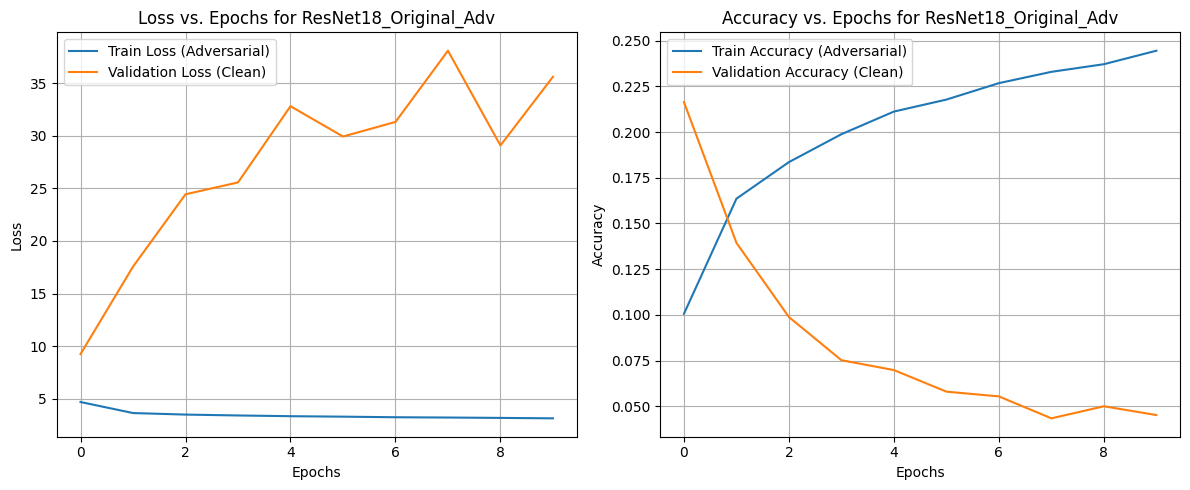


--- Evaluating ResNet18_Original_Adv ---

--- Starting Adversarial Training for: ResNet18_Noisy_Adv ---


Epoch 1/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.3582, Acc=0.1619]


Epoch 1/10 | Train Loss: 3.6919, Train Acc: 0.1619 | Val Loss: 33.9422, Val Acc: 0.0386


Epoch 2/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.8886, Acc=0.1898]


Epoch 2/10 | Train Loss: 3.4641, Train Acc: 0.1898 | Val Loss: 28.8622, Val Acc: 0.0378


Epoch 3/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.4165, Acc=0.1973]


Epoch 3/10 | Train Loss: 3.4069, Train Acc: 0.1973 | Val Loss: 25.1229, Val Acc: 0.0356


Epoch 4/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.1681, Acc=0.2046]


Epoch 4/10 | Train Loss: 3.3822, Train Acc: 0.2046 | Val Loss: 26.1561, Val Acc: 0.0422


Epoch 5/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.4879, Acc=0.2108]


Epoch 5/10 | Train Loss: 3.3451, Train Acc: 0.2108 | Val Loss: 27.9483, Val Acc: 0.0384


Epoch 6/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.2028, Acc=0.2162]


Epoch 6/10 | Train Loss: 3.3163, Train Acc: 0.2162 | Val Loss: 27.5243, Val Acc: 0.0308


Epoch 7/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.3935, Acc=0.2156]


Epoch 7/10 | Train Loss: 3.3086, Train Acc: 0.2156 | Val Loss: 32.2075, Val Acc: 0.0294


Epoch 8/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s, Loss=3.3462, Acc=0.2199]


Epoch 8/10 | Train Loss: 3.2865, Train Acc: 0.2199 | Val Loss: 28.5099, Val Acc: 0.0294


Epoch 9/10 [Adv. Train]: 100%|██████████| 352/352 [02:58<00:00,  1.98it/s, Loss=3.3393, Acc=0.2218]


Epoch 9/10 | Train Loss: 3.2770, Train Acc: 0.2218 | Val Loss: 29.8381, Val Acc: 0.0320


Epoch 10/10 [Adv. Train]: 100%|██████████| 352/352 [02:57<00:00,  1.98it/s, Loss=3.5190, Acc=0.2239]


Epoch 10/10 | Train Loss: 3.2648, Train Acc: 0.2239 | Val Loss: 25.3403, Val Acc: 0.0354


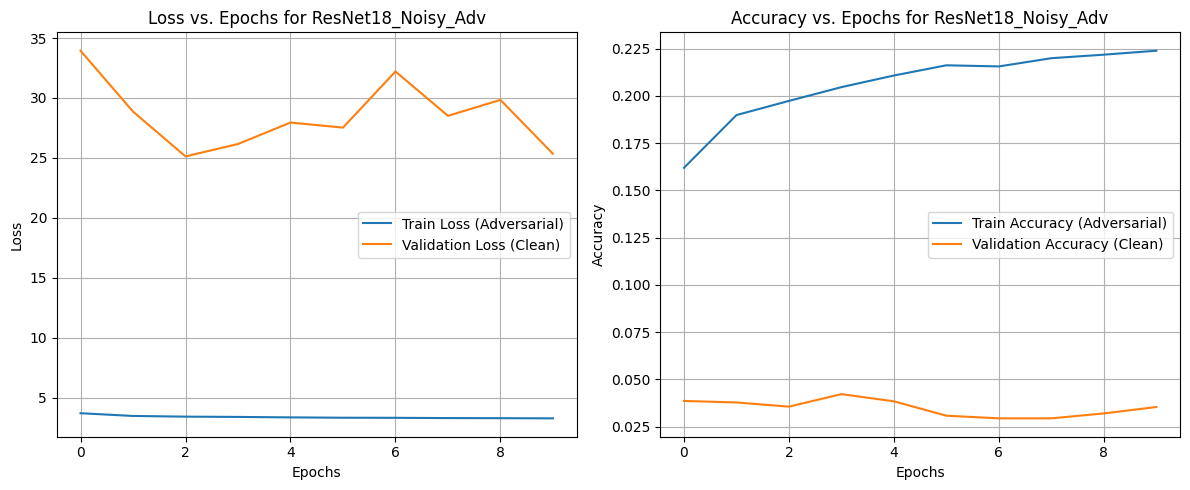


--- Evaluating ResNet18_Noisy_Adv ---

--- Starting Adversarial Training for: ViT_FineTuned_Adv ---


Epoch 1/10 [Adv. Train]: 100%|██████████| 16/16 [09:44<00:00, 36.55s/it, Loss=4.9087, Acc=0.0000]


Epoch 1/10 | Train Loss: 5.6814, Train Acc: 0.0000 | Val Loss: 4.3866, Val Acc: 0.1127


Epoch 2/10 [Adv. Train]: 100%|██████████| 16/16 [02:08<00:00,  8.03s/it, Loss=4.7539, Acc=0.0029]


Epoch 2/10 | Train Loss: 4.7404, Train Acc: 0.0029 | Val Loss: 4.5383, Val Acc: 0.0441


Epoch 3/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.59s/it, Loss=4.6437, Acc=0.0059]


Epoch 3/10 | Train Loss: 4.6545, Train Acc: 0.0059 | Val Loss: 4.5256, Val Acc: 0.0382


Epoch 4/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.58s/it, Loss=4.6360, Acc=0.0098]


Epoch 4/10 | Train Loss: 4.6180, Train Acc: 0.0098 | Val Loss: 4.4865, Val Acc: 0.0657


Epoch 5/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.59s/it, Loss=4.4933, Acc=0.0294]


Epoch 5/10 | Train Loss: 4.5430, Train Acc: 0.0294 | Val Loss: 4.3657, Val Acc: 0.0598


Epoch 6/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.60s/it, Loss=4.2207, Acc=0.0412]


Epoch 6/10 | Train Loss: 4.3787, Train Acc: 0.0412 | Val Loss: 4.1147, Val Acc: 0.0902


Epoch 7/10 [Adv. Train]: 100%|██████████| 16/16 [02:18<00:00,  8.64s/it, Loss=4.1644, Acc=0.0412]


Epoch 7/10 | Train Loss: 4.1402, Train Acc: 0.0412 | Val Loss: 3.8327, Val Acc: 0.1765


Epoch 8/10 [Adv. Train]: 100%|██████████| 16/16 [02:25<00:00,  9.11s/it, Loss=3.8727, Acc=0.0725]


Epoch 8/10 | Train Loss: 3.8840, Train Acc: 0.0725 | Val Loss: 3.6445, Val Acc: 0.2294


Epoch 9/10 [Adv. Train]: 100%|██████████| 16/16 [02:25<00:00,  9.07s/it, Loss=3.4590, Acc=0.1294]


Epoch 9/10 | Train Loss: 3.6449, Train Acc: 0.1294 | Val Loss: 3.4205, Val Acc: 0.2529


Epoch 10/10 [Adv. Train]: 100%|██████████| 16/16 [02:20<00:00,  8.76s/it, Loss=3.4087, Acc=0.1598]


Epoch 10/10 | Train Loss: 3.3827, Train Acc: 0.1598 | Val Loss: 3.1901, Val Acc: 0.3284


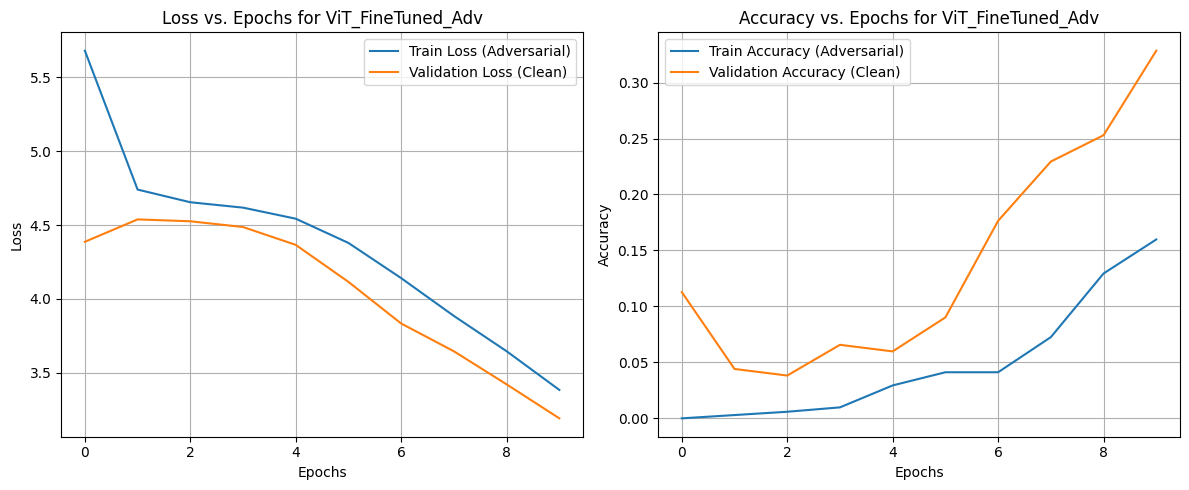


--- Evaluating ViT_FineTuned_Adv ---

--- Starting Adversarial Training for: ViT_From_Scratch_Adv ---


Epoch 1/10 [Adv. Train]: 100%|██████████| 16/16 [02:16<00:00,  8.51s/it, Loss=4.7510, Acc=0.0039]


Epoch 1/10 | Train Loss: 5.1185, Train Acc: 0.0039 | Val Loss: 4.5063, Val Acc: 0.0235


Epoch 2/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.61s/it, Loss=4.7051, Acc=0.0069]


Epoch 2/10 | Train Loss: 4.6829, Train Acc: 0.0069 | Val Loss: 4.4705, Val Acc: 0.0304


Epoch 3/10 [Adv. Train]: 100%|██████████| 16/16 [02:19<00:00,  8.73s/it, Loss=4.3664, Acc=0.0167]


Epoch 3/10 | Train Loss: 4.5403, Train Acc: 0.0167 | Val Loss: 4.5379, Val Acc: 0.0392


Epoch 4/10 [Adv. Train]: 100%|██████████| 16/16 [02:23<00:00,  8.98s/it, Loss=4.2854, Acc=0.0206]


Epoch 4/10 | Train Loss: 4.3792, Train Acc: 0.0206 | Val Loss: 4.6092, Val Acc: 0.0363


Epoch 5/10 [Adv. Train]: 100%|██████████| 16/16 [02:16<00:00,  8.52s/it, Loss=4.3611, Acc=0.0294]


Epoch 5/10 | Train Loss: 4.2565, Train Acc: 0.0294 | Val Loss: 4.6341, Val Acc: 0.0392


Epoch 6/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.57s/it, Loss=4.2410, Acc=0.0510]


Epoch 6/10 | Train Loss: 4.1284, Train Acc: 0.0510 | Val Loss: 4.7317, Val Acc: 0.0402


Epoch 7/10 [Adv. Train]: 100%|██████████| 16/16 [02:19<00:00,  8.71s/it, Loss=4.2829, Acc=0.0471]


Epoch 7/10 | Train Loss: 4.0003, Train Acc: 0.0471 | Val Loss: 4.8389, Val Acc: 0.0343


Epoch 8/10 [Adv. Train]: 100%|██████████| 16/16 [02:16<00:00,  8.56s/it, Loss=4.0654, Acc=0.0539]


Epoch 8/10 | Train Loss: 3.9131, Train Acc: 0.0539 | Val Loss: 4.5546, Val Acc: 0.0471


Epoch 9/10 [Adv. Train]: 100%|██████████| 16/16 [02:23<00:00,  8.94s/it, Loss=4.0409, Acc=0.0676]


Epoch 9/10 | Train Loss: 3.8460, Train Acc: 0.0676 | Val Loss: 4.5863, Val Acc: 0.0451


Epoch 10/10 [Adv. Train]: 100%|██████████| 16/16 [02:17<00:00,  8.58s/it, Loss=3.8237, Acc=0.0941]


Epoch 10/10 | Train Loss: 3.7261, Train Acc: 0.0941 | Val Loss: 4.5706, Val Acc: 0.0382


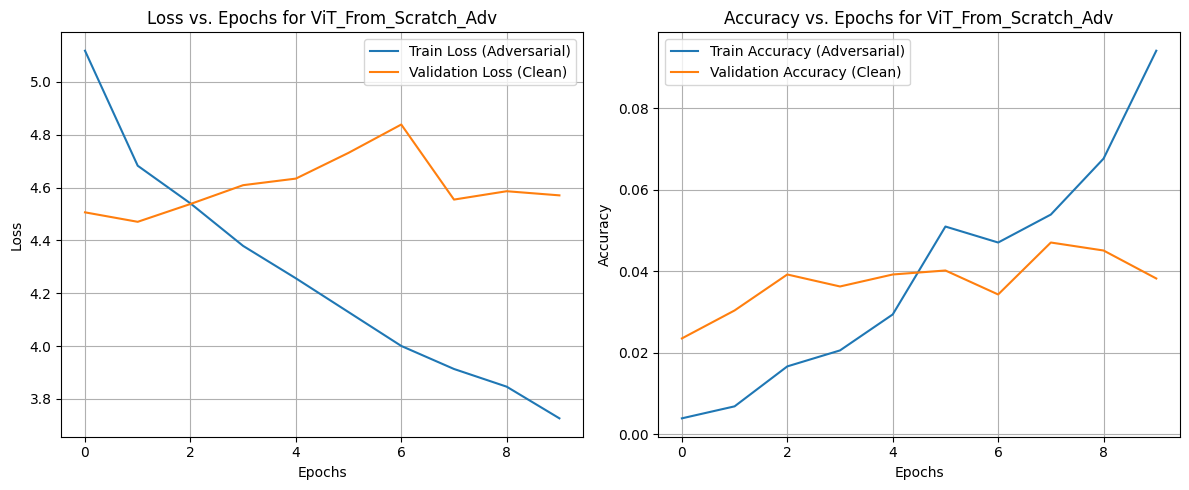


--- Evaluating ViT_From_Scratch_Adv ---


                    Final Performance After Adversarial Training
                Model  Clean Accuracy (%)  FGSM Accuracy (%)  PGD Accuracy (%)
ResNet18_Original_Adv            4.810000          44.570000         24.230000
   ResNet18_Noisy_Adv            3.240000          28.760000         16.960000
    ViT_FineTuned_Adv           25.435030          17.515043          8.115141
 ViT_From_Scratch_Adv            4.195804           8.668076          5.529354


In [ ]:
model_configs = [
    {"name": "ResNet18_Original_Adv", "model": ResNet18_Original, "train_loader": train_loader, "val_loader": val_loader, "test_loader": test_loader, "type": "resnet"},
    {"name": "ResNet18_Noisy_Adv", "model": ResNet18_Noisy, "train_loader": train_loader_noisy, "val_loader": val_loader_noisy, "test_loader": test_loader, "type": "resnet"},
    {"name": "ViT_FineTuned_Adv", "model": ViT_FineTuned, "train_loader": train_loader_vit, "val_loader": val_loader_vit, "test_loader": test_loader_vit, "type": "vit"},
    {"name": "ViT_From_Scratch_Adv", "model": ViT_From_Scratch, "train_loader": train_loader_vit, "val_loader": val_loader_vit, "test_loader": test_loader_vit, "type": "vit"}
]

final_results = []

for config in model_configs:
    model_name = config["name"]
    model = config["model"]
    model_type = config["type"]

    if model_type == 'vit':
        model = ViTWrapper(model).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    adv_trained_model = adversarial_train_model(model, config["train_loader"], config["val_loader"], optimizer, None, NUM_EPOCHS_ADV, model_name, model_type)

    print(f"\n--- Evaluating {model_name} ---")

    clean_acc = evaluate_clean(adv_trained_model, config["test_loader"], model_type)

    fgsm_attack = torchattacks.FGSM(adv_trained_model, eps=EPS_FGSM)
    fgsm_acc = evaluate_adversarial(adv_trained_model, config["test_loader"], fgsm_attack, model_type)

    pgd_attack = torchattacks.PGD(adv_trained_model, eps=EPS_PGD, alpha=ALPHA_PGD, steps=STEPS_PGD)
    pgd_acc = evaluate_adversarial(adv_trained_model, config["test_loader"], pgd_attack, model_type)

    final_results.append({
        "Model": model_name,
        "Clean Accuracy (%)": clean_acc,
        "FGSM Accuracy (%)": fgsm_acc,
        "PGD Accuracy (%)": pgd_acc
    })


print("\n\n" + "="*80)
print(" " * 20 + "Final Performance After Adversarial Training")
print("="*80)

results_df = pd.DataFrame(final_results)
print(results_df.to_string(index=False))
print("="*80)

## Bonus: Use Grad-CAM

In [ ]:
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    tensor = tensor.cpu() * std + mean
    return torch.clamp(tensor, 0, 1)

In [ ]:
testset_vis = torchvision.datasets.CIFAR100(root=base_path, train=False, download=True)
cifar_samples = [testset_vis[i] for i in [100, 200, 300, 400]]
flower_samples = [test_dataset[i] for i in [100, 200, 300, 400]]

In [ ]:
## Base models (without adversarial training)
ResNet18_Original.load_state_dict(torch.load(os.path.join(base_path, "best_ResNet18_Original.pth"), map_location=device))
ResNet18_Noisy.load_state_dict(torch.load(os.path.join(base_path, "best_ResNet18_Noisy.pth"), map_location=device))
ViT_FineTuned.load_state_dict(torch.load(os.path.join(base_path, "vit_flowers102/best_model_ViT_FineTuned.pth"), map_location=device))
ViT_From_Scratch.load_state_dict(torch.load(os.path.join(base_path, "vit_flowers102/best_model_ViT_From_Scratch.pth"), map_location=device))

<All keys matched successfully>

In [ ]:
ResNet18_Original_adv = create_resnet18_cifar()
ResNet18_Noisy_adv = create_resnet18_cifar()

ViT_FineTuned_adv = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

config = ViTConfig.from_pretrained(model_checkpoint, num_labels=num_classes)
ViT_From_Scratch_adv = ViTForImageClassification(config)

In [ ]:
ResNet18_Original_adv.load_state_dict(torch.load(base_path + "/adversarially_trained/best_adv_ResNet18_Original_Adv.pth", map_location=device))
ResNet18_Noisy_adv.load_state_dict(torch.load(base_path + "/adversarially_trained/best_adv_ResNet18_Noisy_Adv.pth", map_location=device))
ViT_FineTuned_adv.load_state_dict(torch.load(base_path + "/adversarially_trained/best_adv_ViT_FineTuned_Adv.pth", map_location=device))
ViT_From_Scratch_adv.load_state_dict(torch.load(base_path + "/adversarially_trained/best_adv_ViT_From_Scratch_Adv.pth", map_location=device))

<All keys matched successfully>

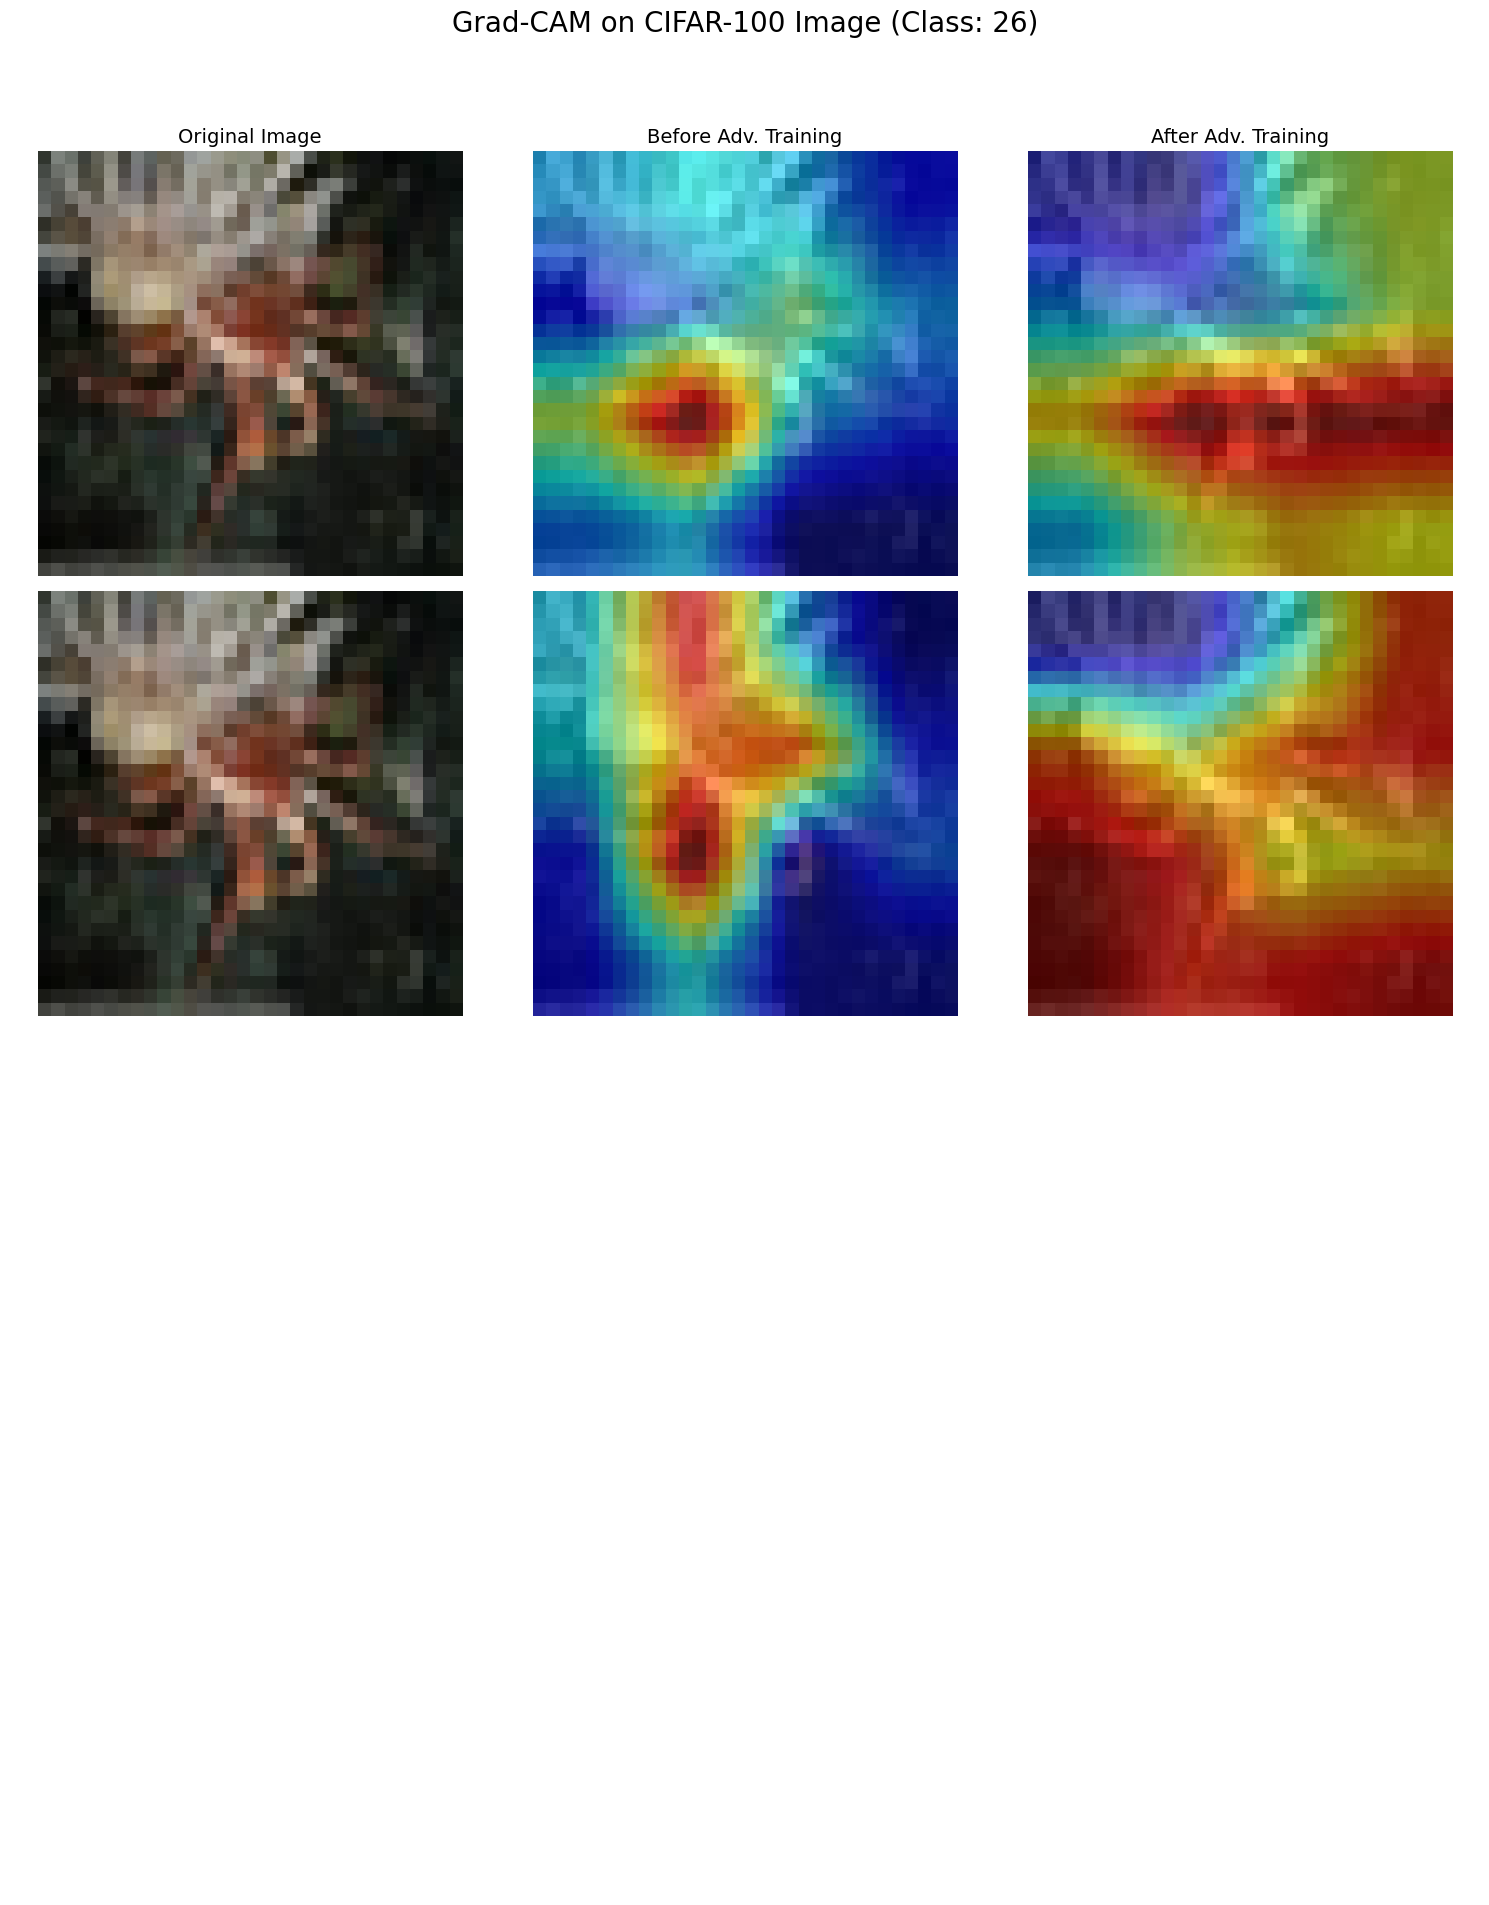

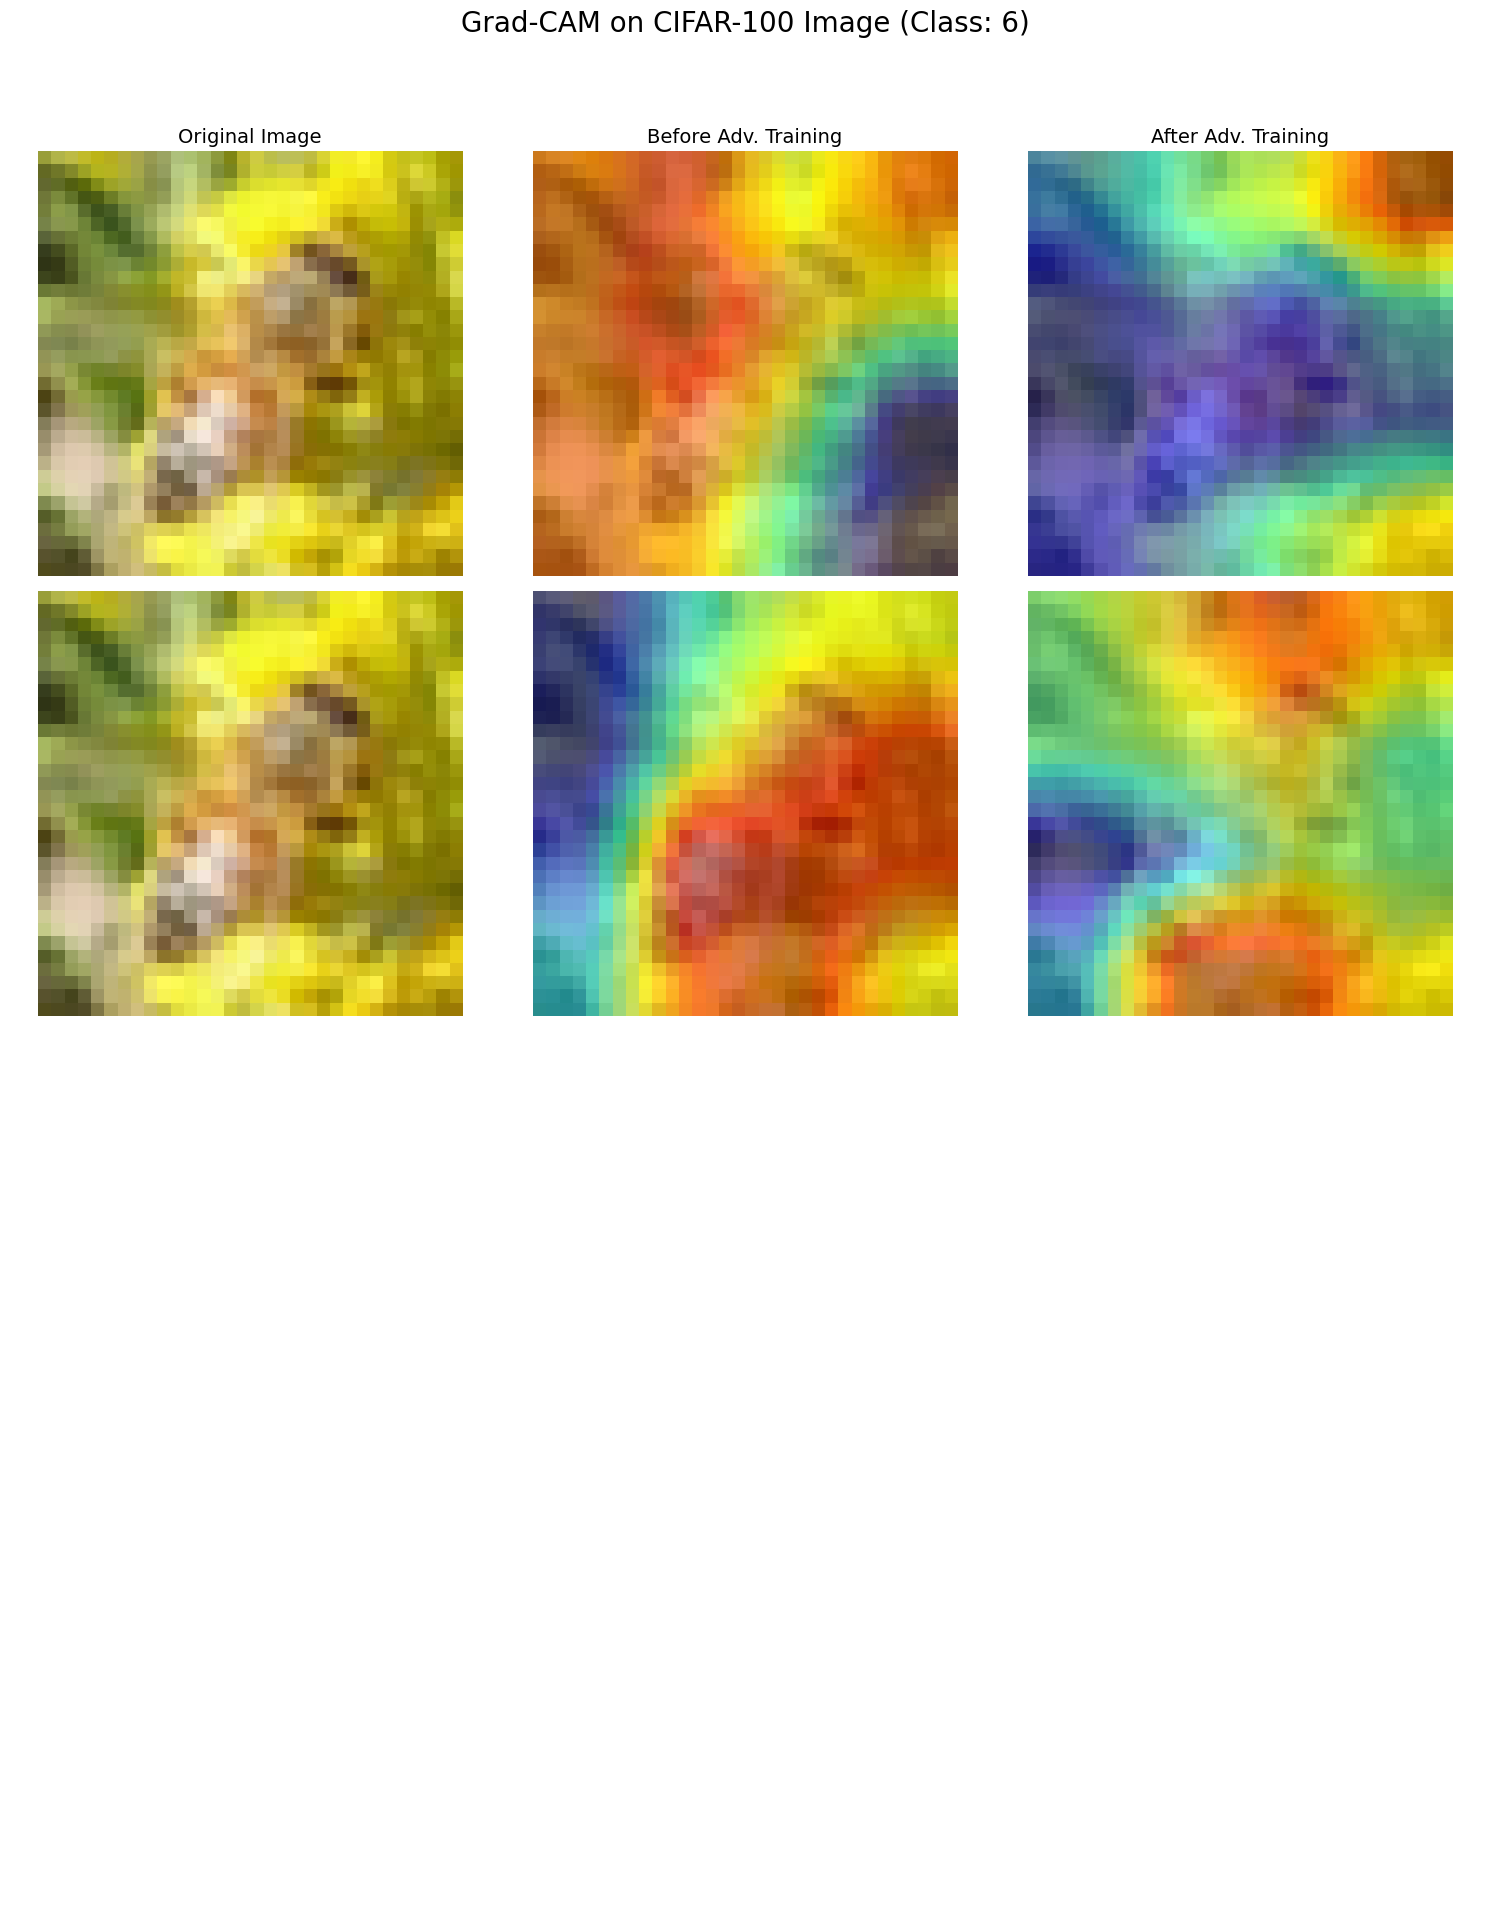

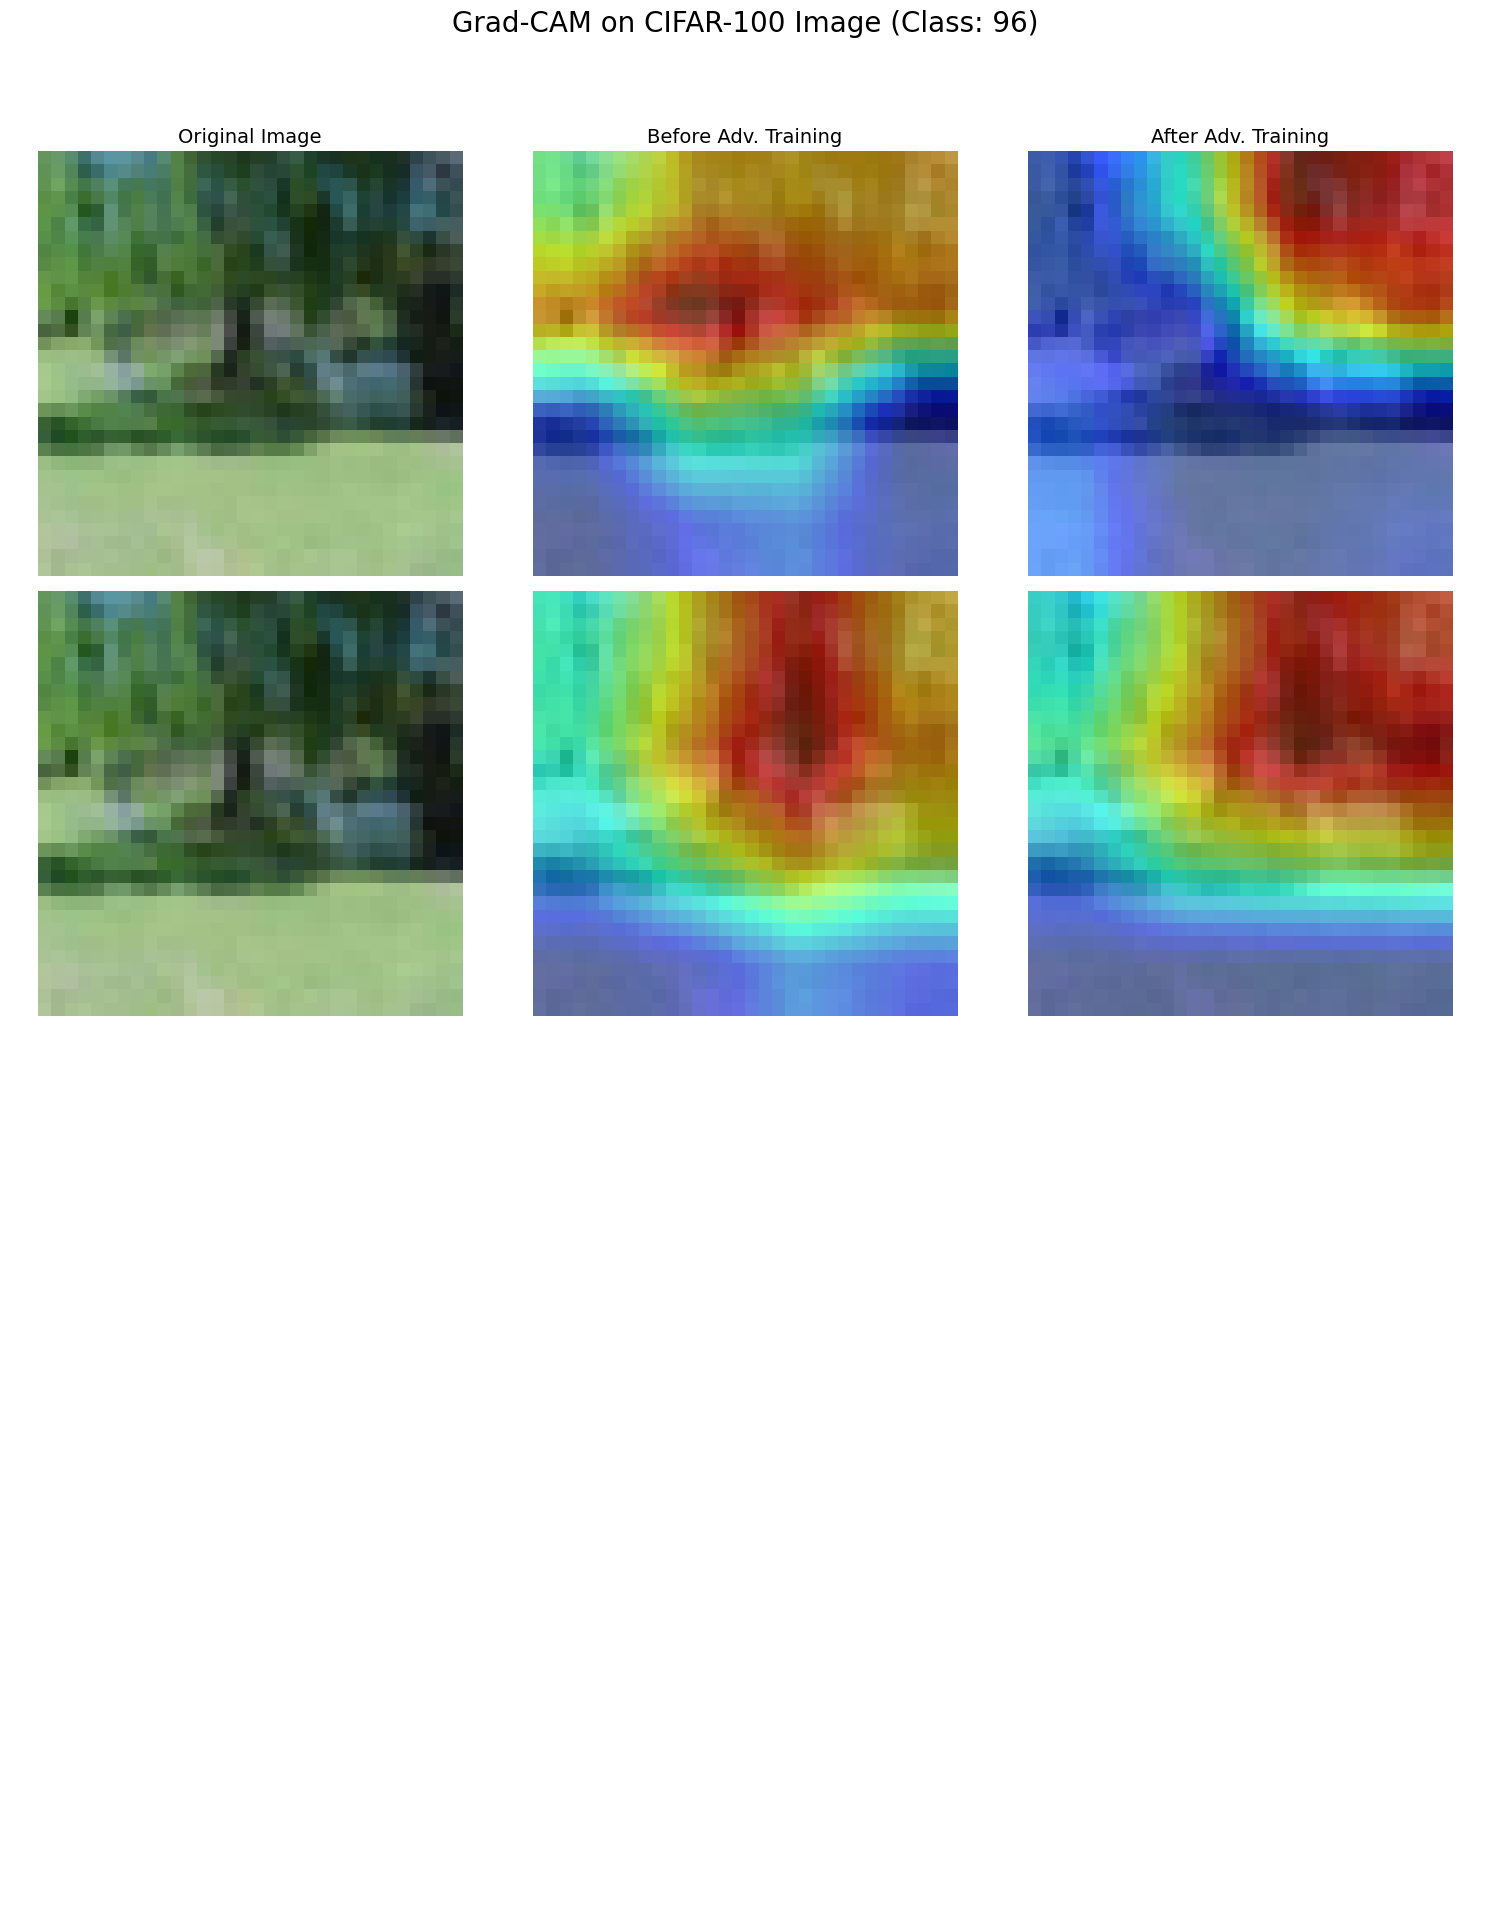

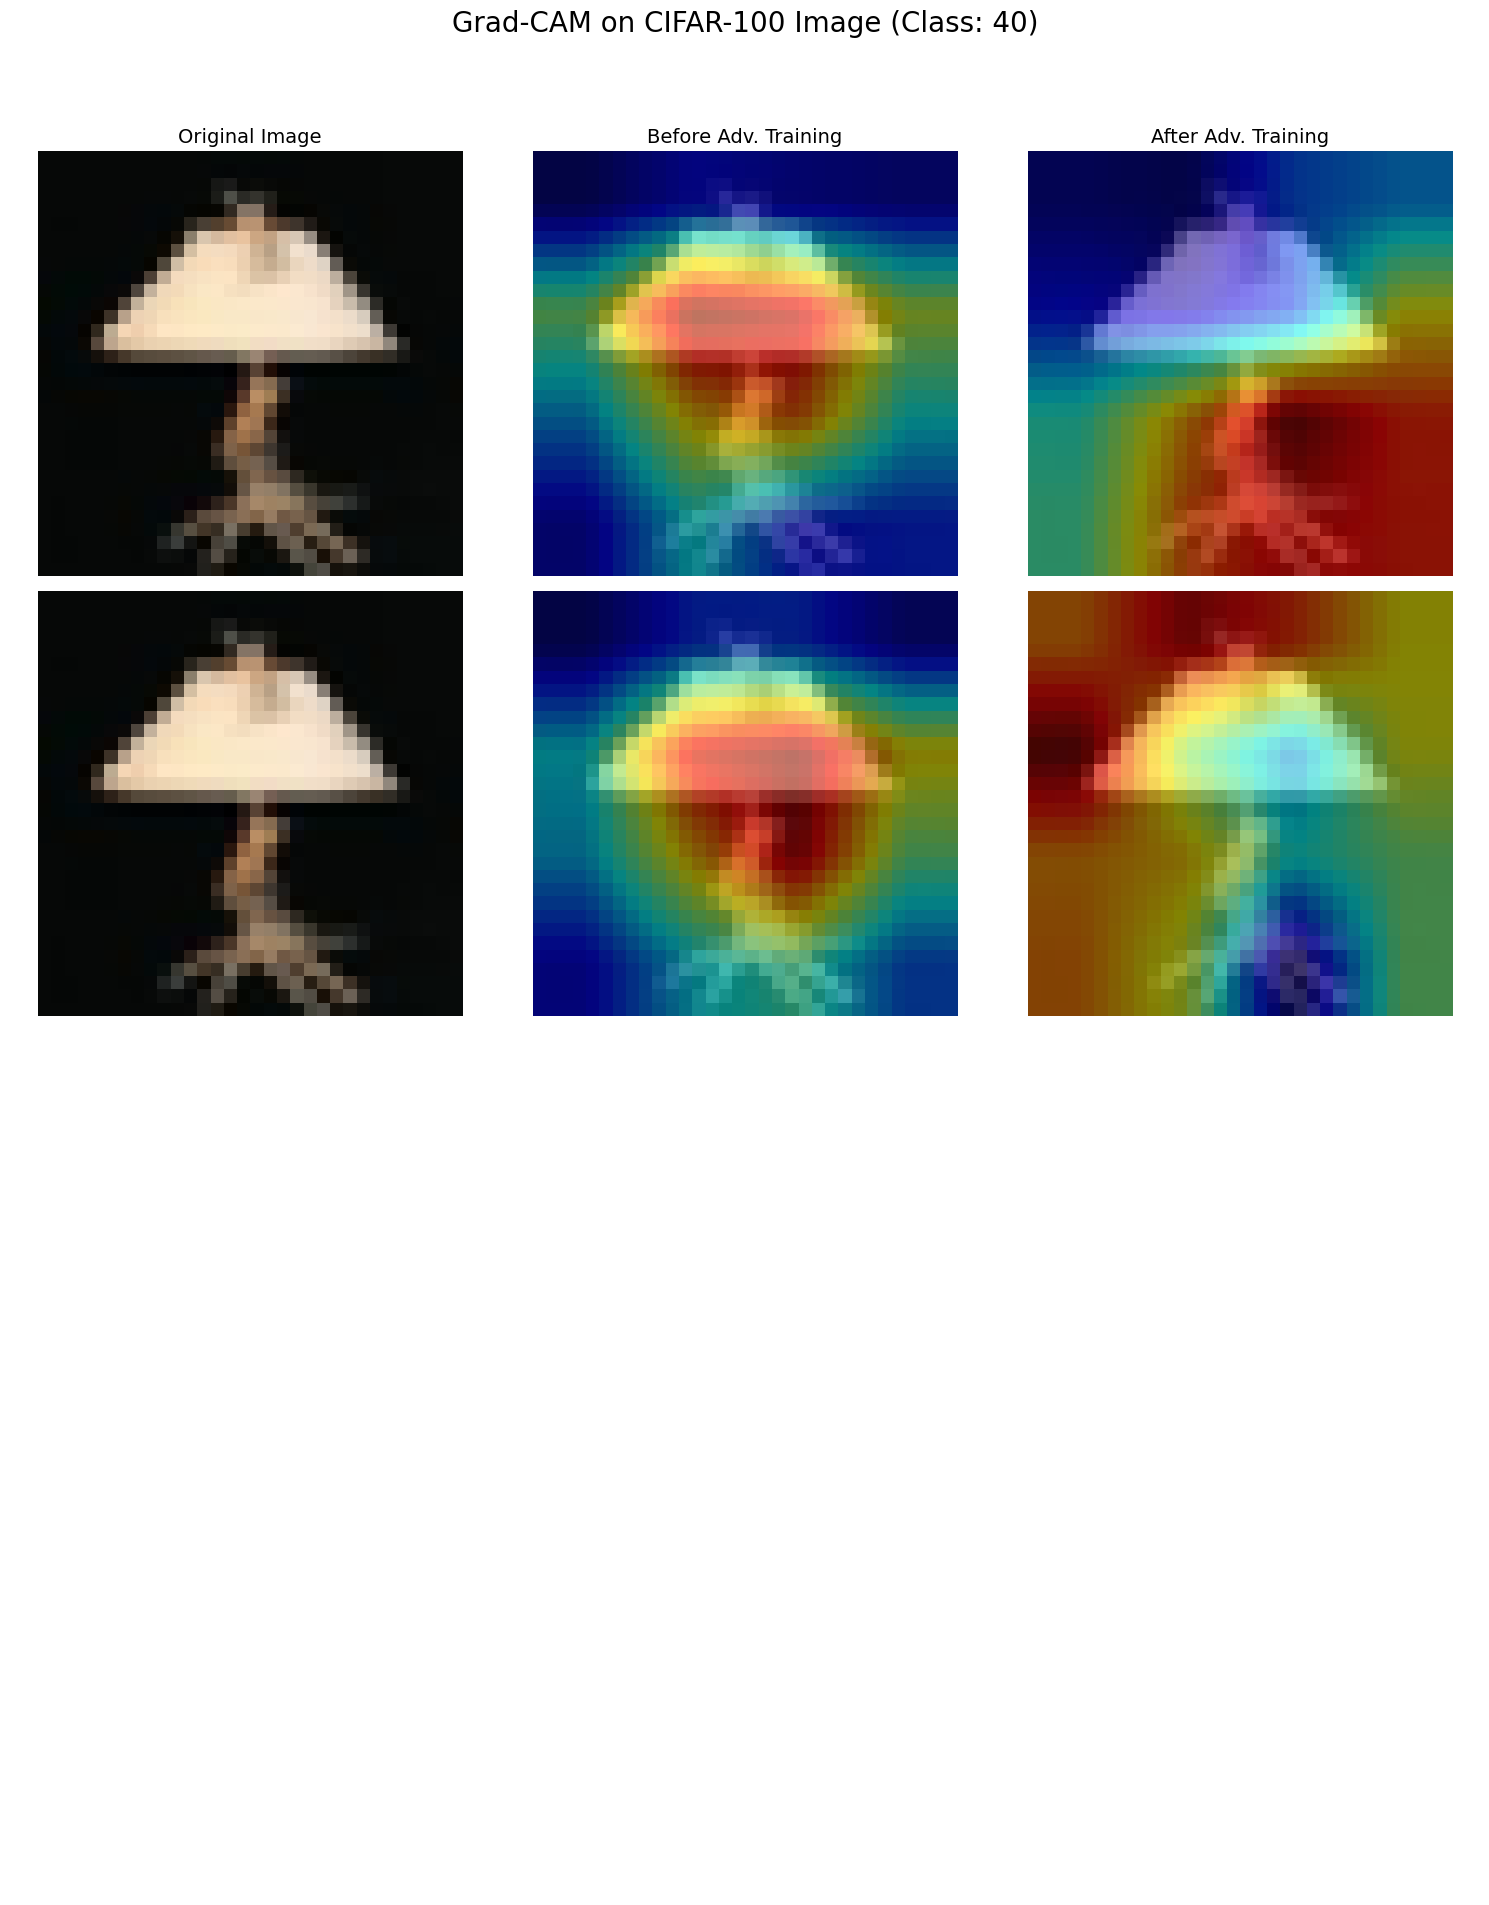

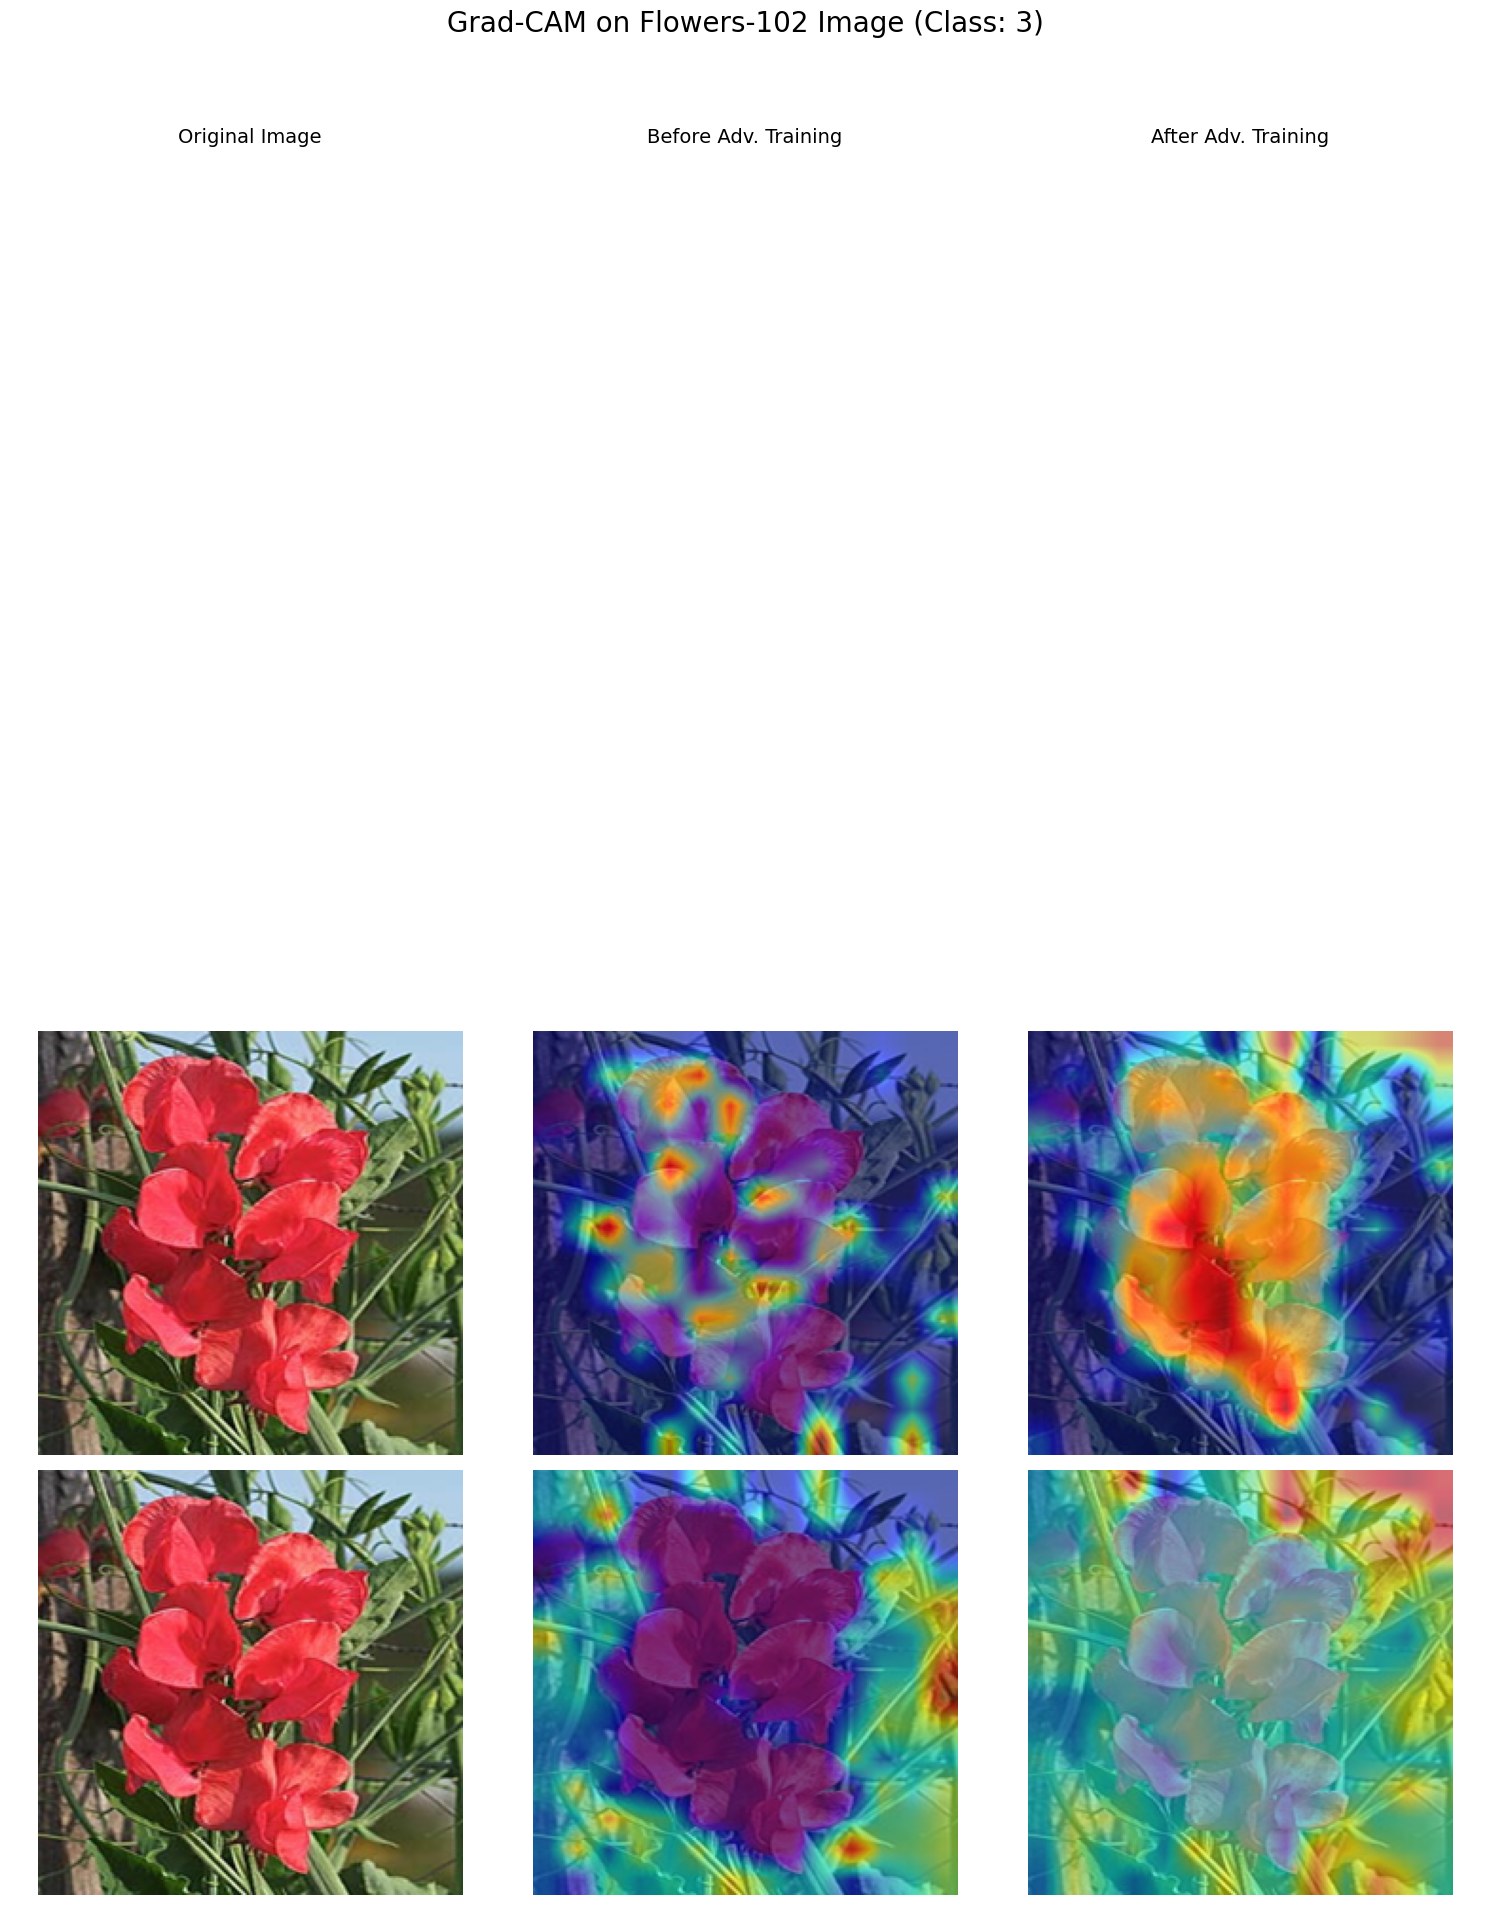

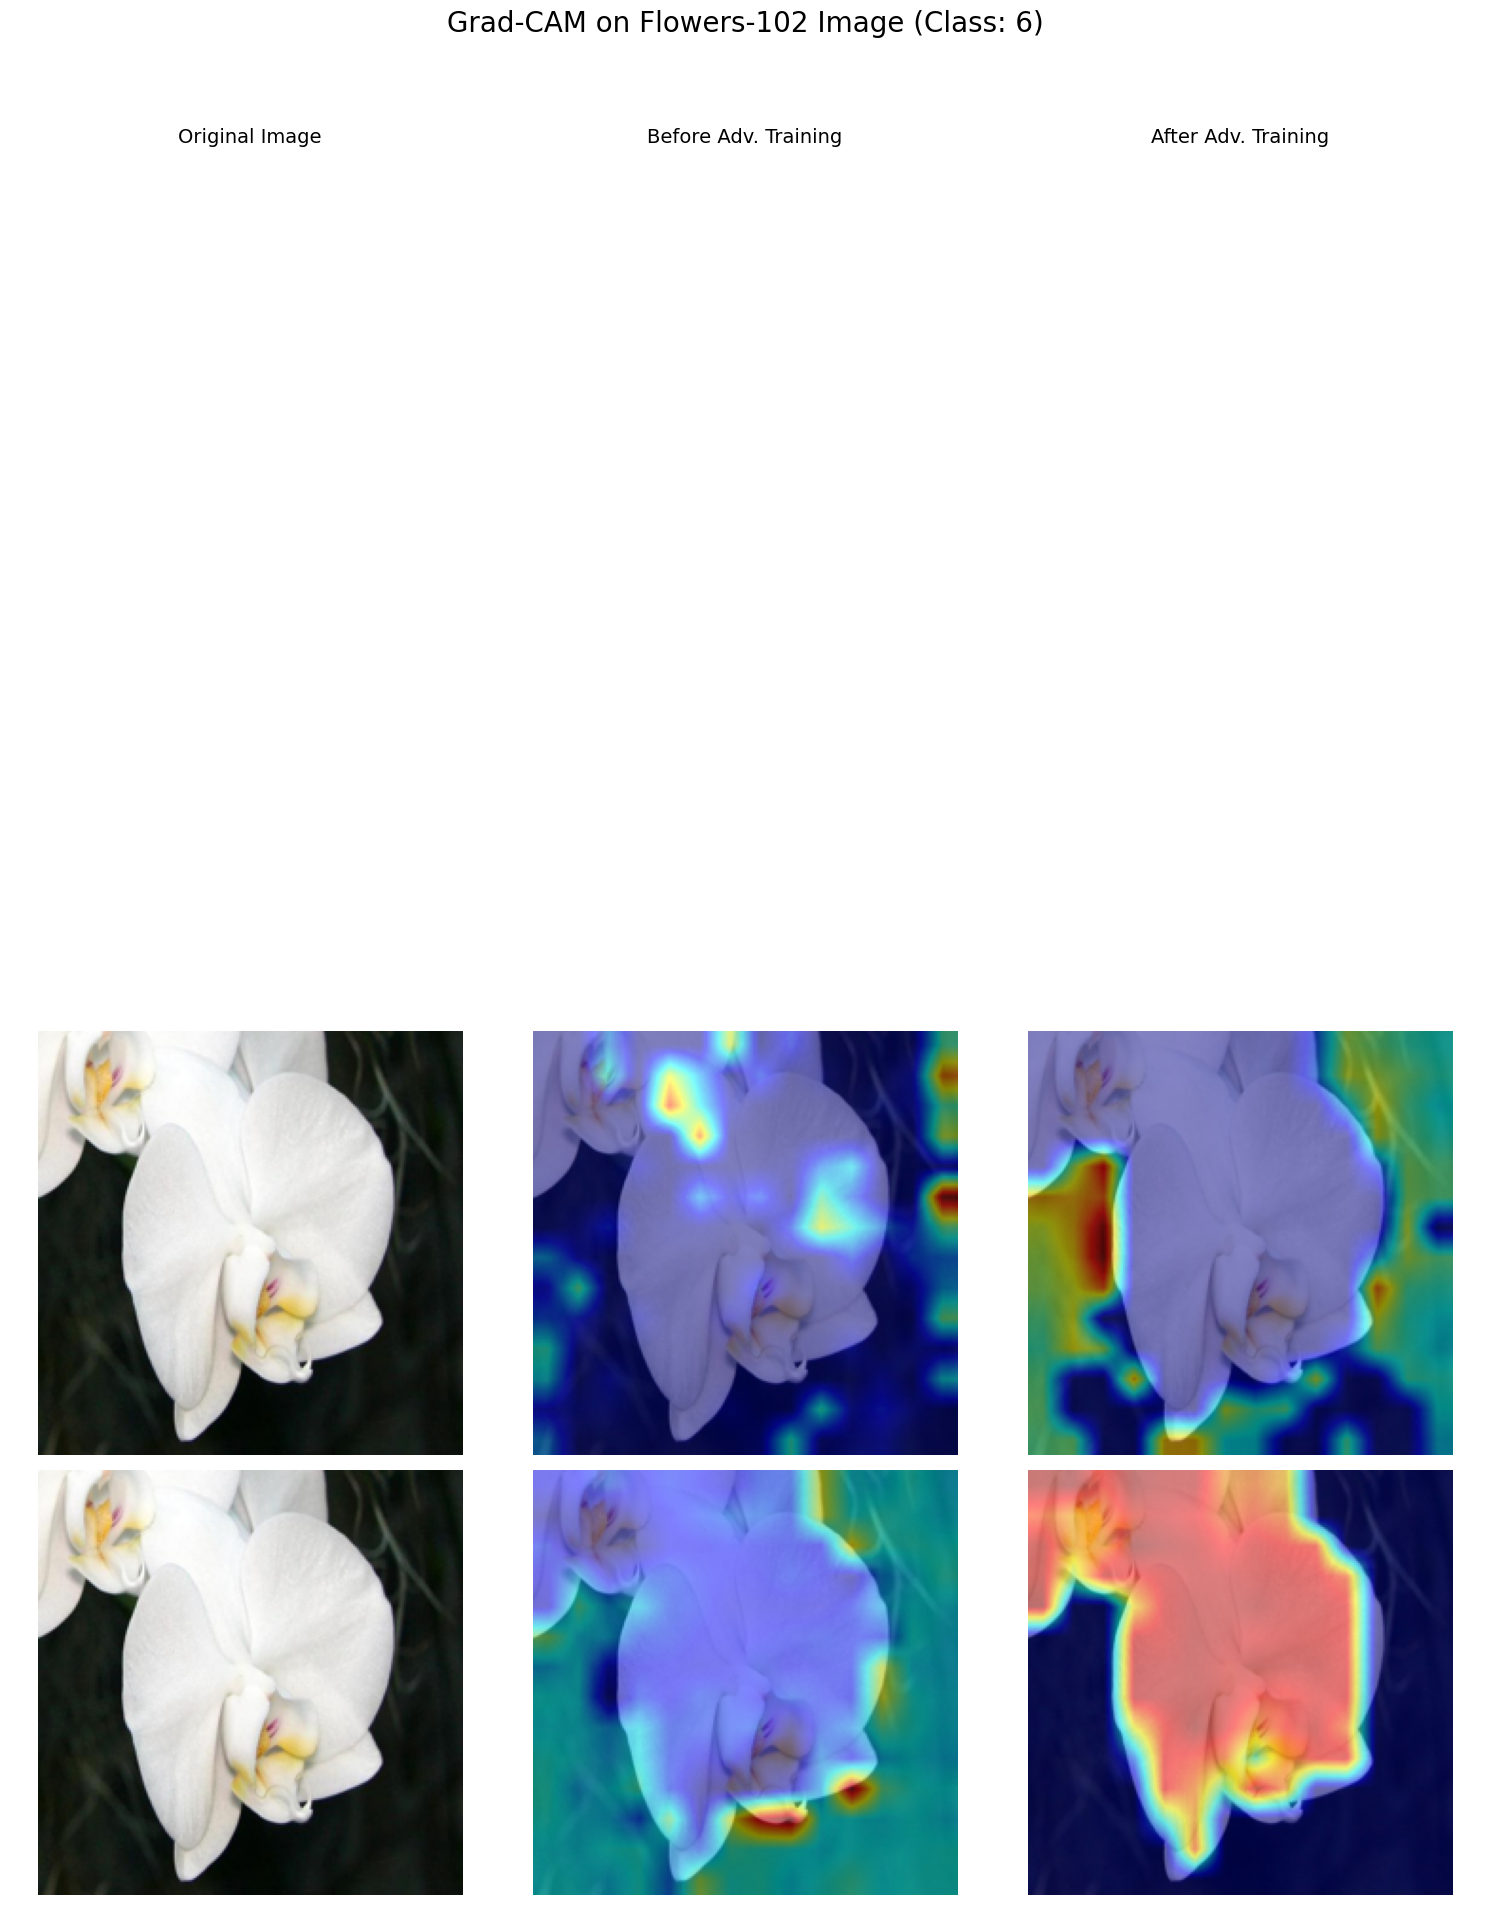

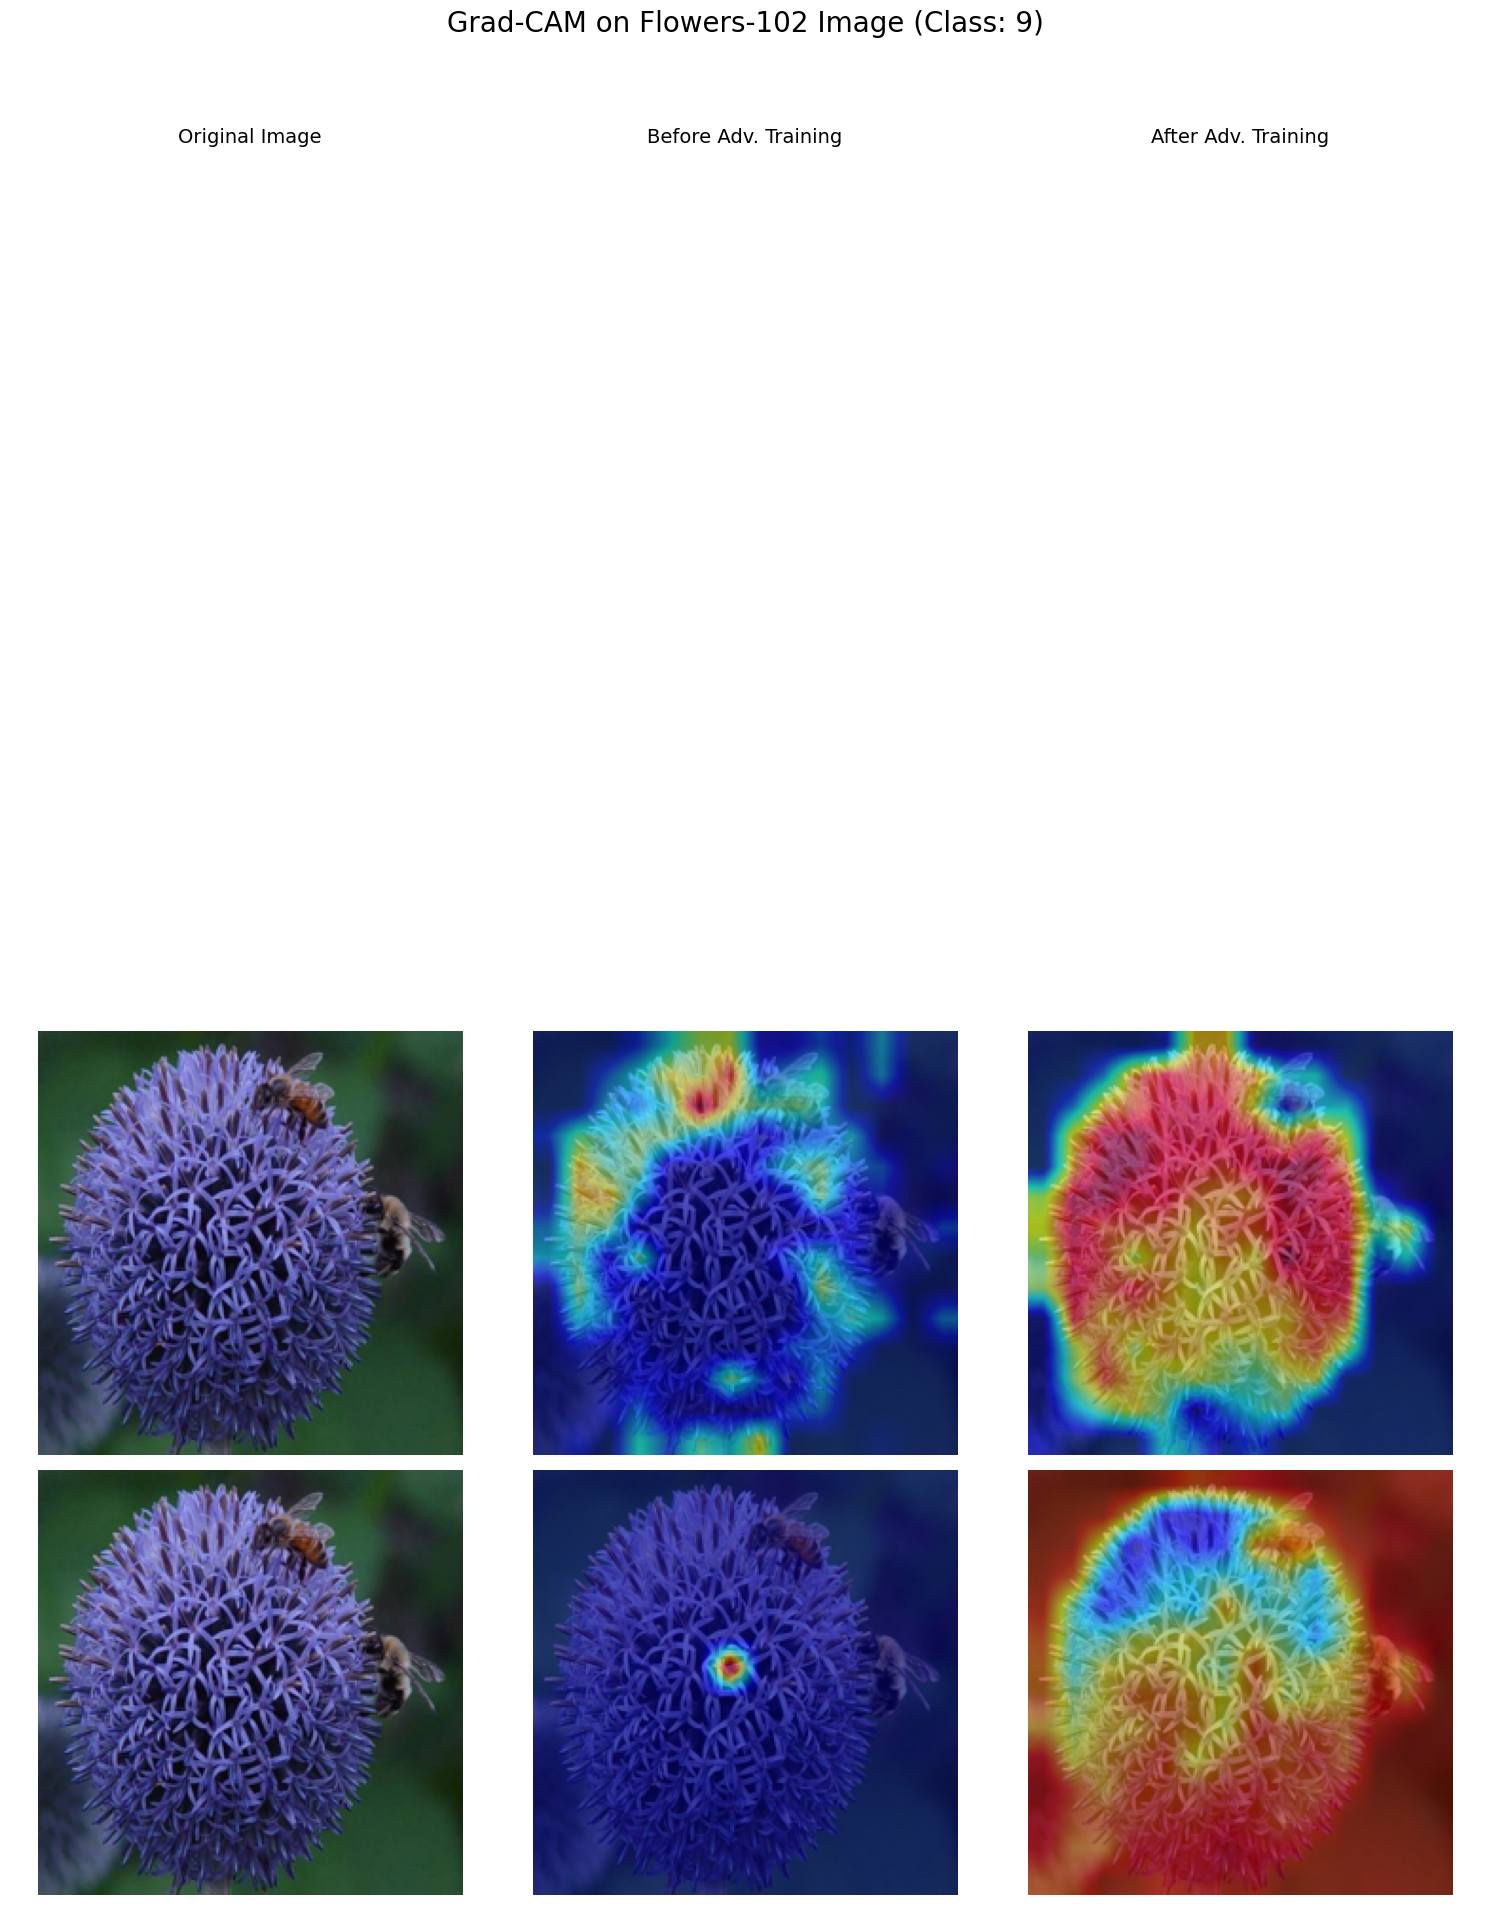

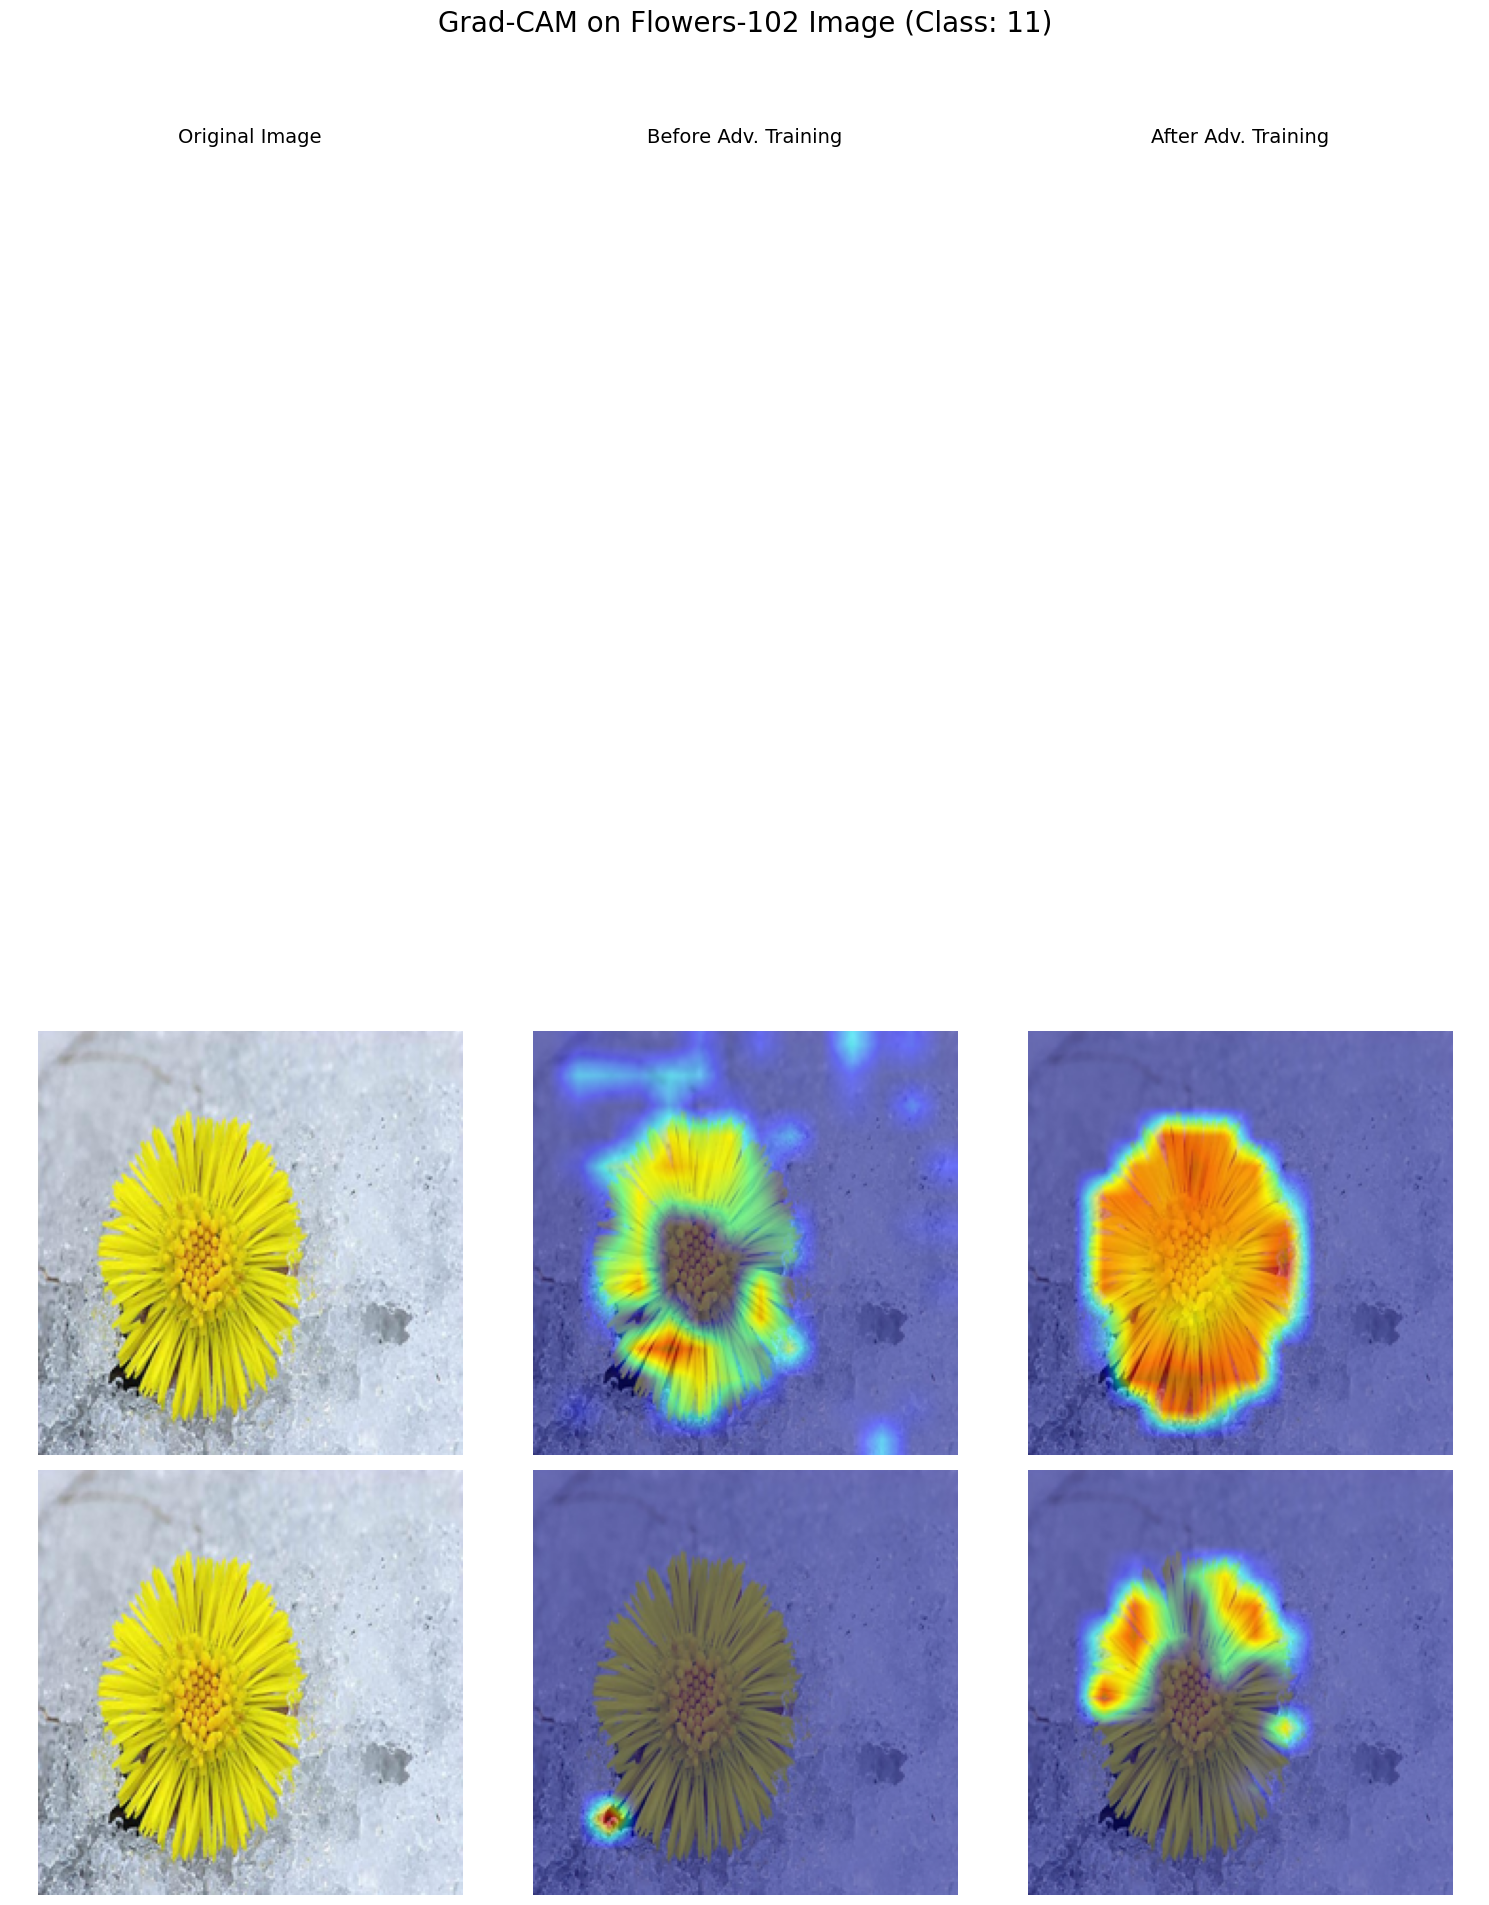

In [ ]:
models_to_visualize = {
    "ResNet Original": (ResNet18_Original, ResNet18_Original_adv),
    "ResNet Noisy": (ResNet18_Noisy, ResNet18_Noisy_adv),
    "ViT Fine-Tuned": (ViT_FineTuned, ViT_FineTuned_adv),
    "ViT From Scratch": (ViT_From_Scratch, ViT_From_Scratch_adv)
}

target_layers_config = {
    "ResNet": lambda m: [m.layer4[-1]],
    "ViT": lambda m: [m.vit.encoder.layer[-1].layernorm_before]
}

for i, (sample_image, sample_label) in enumerate(cifar_samples + flower_samples):
    is_cifar = i < 4
    dataset_name = "CIFAR-100" if is_cifar else "Flowers-102"

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(f'Grad-CAM on {dataset_name} Image (Class: {sample_label})', fontsize=20)

    cols = ['Original Image', 'Before Adv. Training', 'After Adv. Training']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col, fontsize=14)

    for j, (model_name_root, (model_before, model_after)) in enumerate(models_to_visualize.items()):
        model_type = "ViT" if "ViT" in model_name_root else "ResNet"
        axs[j, 0].set_ylabel(model_name_root, rotation=90, size='large')

        if (is_cifar and model_type == "ViT") or (not is_cifar and model_type == "ResNet"):
            for k in range(3): axs[j, k].axis('off')
            continue

        if model_type == "ViT":
            input_tensor = processor_vit(sample_image, return_tensors='pt')['pixel_values'].to(device)
            rgb_img = np.array(sample_image.resize((224, 224))) / 255.0
        else:
            transform = testset.transform
            input_tensor = transform(sample_image).unsqueeze(0).to(device)
            normalize_transform = next((t for t in transform.transforms if isinstance(t, torchvision.transforms.Normalize)), None)
            if normalize_transform:
                 rgb_img = denormalize(input_tensor.squeeze(0), normalize_transform.mean, normalize_transform.std).permute(1, 2, 0).numpy()
            else:
                 rgb_img = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

        axs[j, 0].imshow(rgb_img)
        axs[j, 0].axis('off')

        model_before_wrapped = ViTWrapper(model_before).to(device) if model_type == "ViT" else model_before
        target_layers_before = target_layers_config[model_type](model_before)
        cam_before = GradCAM(model=model_before_wrapped, target_layers=target_layers_before, reshape_transform=reshape_transform_vit if model_type == "ViT" else None)
        grayscale_cam_before = cam_before(input_tensor=input_tensor, targets=None)[0, :]
        vis_before = show_cam_on_image(rgb_img, grayscale_cam_before, use_rgb=True)
        axs[j, 1].imshow(vis_before)
        axs[j, 1].axis('off')

        model_after_wrapped = ViTWrapper(model_after).to(device) if model_type == "ViT" else model_after
        target_layers_after = target_layers_config[model_type](model_after)
        cam_after = GradCAM(model=model_after_wrapped, target_layers=target_layers_after, reshape_transform=reshape_transform_vit if model_type == "ViT" else None)
        grayscale_cam_after = cam_after(input_tensor=input_tensor, targets=None)[0, :]
        vis_after = show_cam_on_image(rgb_img, grayscale_cam_after, use_rgb=True)
        axs[j, 2].imshow(vis_after)
        axs[j, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()